In [1]:
import math
import gc
import pickle
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from optuna.samplers import RandomSampler, TPESampler, GPSampler
import warnings
warnings.filterwarnings("ignore")
# import multiprocessing
# max_n_jobs = multiprocessing.cpu_count()
import shap
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, Sampler
import torch.nn as nn
import torch.optim as optim
import mlx.core as mx
import mlx.nn as nnmx
import mlx.optimizers as optimmx

/Users/justpqa/drw-crypto-market-prediction/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
feature_version = 2
# 1 for pc feature, 
# 2 for label correlation feature # seems to work most consistently
# 3 for best features based on combination rank
# 4 for including time features (in case we want to reverse engineer the masked timestamp)
# 5 for increasing number of correlation features + only use those that are in the same cluster
# 6 is for 2 but more features, use when I want to use more features for larger models or AE approaches

In [4]:
default_random_state = 101
random.seed(default_random_state)
np.random.seed(default_random_state)
torch.manual_seed(default_random_state)
torch.mps.manual_seed(default_random_state)
mx.random.seed(default_random_state)

#### Import train data and popular features

In [5]:
train_df = pd.read_parquet(f"data/cleaned/cleaned_train_{feature_version}.parquet")
train_df.head()

,X751,X473,X472,X451,X226,X219,X205,X445,X444,X27,...,X181_X762_X286_exp_interaction,X181_X272_X286_exp_interaction,X181_X272_X288_exp_interaction,X181_X272_X285_exp_interaction,X204_X758_X286_exp_interaction,X204_X758_X288_exp_interaction,X204_X758_X290_exp_interaction,X204_X758_X292_exp_interaction,__index_level_0__,label
0,0.000617,0.362816,0.255354,0.625153,-0.893206,-0.654146,-1.250753,0.755891,0.625328,1.714323,...,0.469463,0.264951,0.248992,0.391404,0.129056,0.121283,0.108972,0.091955,2023-03-01 00:00:00,0.562539
1,0.013388,0.378391,0.274621,0.637250,-0.738291,-0.634723,-1.100357,0.760472,0.633046,1.396133,...,0.443526,0.250629,0.238075,0.374853,0.149914,0.142404,0.128732,0.107978,2023-03-01 00:01:00,0.533686
2,-0.016807,0.382337,0.279272,0.640437,-0.713420,-0.631882,-1.073226,0.761631,0.635009,1.205921,...,0.442458,0.247697,0.235061,0.373425,0.154606,0.146719,0.133283,0.111113,2023-03-01 00:02:00,0.546505
3,-0.036622,0.387473,0.284750,0.642831,-0.644172,-0.612901,-0.982398,0.761936,0.635508,1.419536,...,0.430054,0.245878,0.234839,0.364263,0.171042,0.163363,0.147668,0.124220,2023-03-01 00:03:00,0.357703
4,-0.053322,0.390820,0.289431,0.648175,-0.628840,-0.607648,-0.952145,0.764770,0.640311,1.408936,...,0.432521,0.249067,0.237772,0.370813,0.178625,0.170524,0.154702,0.129949,2023-03-01 00:04:00,0.362452


In [6]:
popular_features_train = pd.read_parquet("data/cleaned/popular_features_train.parquet")
popular_features_train.head()

,volume,bid_qty,ask_qty,buy_qty,sell_qty
0,221.389,15.283,8.425,176.405,44.984
1,847.796,38.590,2.336,525.846,321.950
2,295.596,0.442,60.250,159.227,136.369
3,460.705,4.865,21.016,335.742,124.963
4,142.818,27.158,3.451,98.411,44.407


#### Implement some helper function

In [7]:
# First need to split into some fold
train_df["__index_level_0__"] = pd.to_datetime(train_df["__index_level_0__"])

default_cv = 4
default_cv_type = "full"
# NOTE: default_cv must set to 1 instead of 3 based on consistency with LB score contains 49% of test data
# NOTE: 3 cv with gap is slightly better or almost equal

def create_cv(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["__index_level_0__", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        train_month = list(range(3 + i, 7 + i))
        test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
        print(train_month, test_month)
        # print(train_month, test_month)
        train = train_df[train_df["__index_level_0__"].dt.month.isin(train_month)].reset_index().drop("index", axis = 1)
        test = train_df[train_df["__index_level_0__"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
        X_train_arr.append(train.drop(["__index_level_0__", "label"], axis = 1))
        X_test_arr.append(test.drop(["__index_level_0__", "label"], axis = 1))
        Y_train_arr.append(train["label"])
        Y_test_arr.append(test["label"])  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

# def create_cv_random_test(train_df, features=None, test_cv=10):
#     # randomize so that we have 1 train, but try it on 10 different test 
#     if features is not None:
#         train_df = train_df[features + ["timestamp", "label"]]
#     X_train_arr = []
#     X_test_arr = []
#     Y_train_arr = []
#     Y_test_arr = []

#     # Create train data
#     train_month = [3, 4, 5, 6, 7, 8]
#     train = train_df[train_df["timestamp"].dt.month.isin(train_month)] 
#     X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
#     Y_train_arr.append(train["label"])

#     test_month = [9, 10, 11, 12, 1, 2]
#     test = train_df[train_df["timestamp"].dt.month.isin(test_month)]
#     # Create test data
#     for _ in range(test_cv):
#         random_test = test.sample(frac = 0.5, random_state = default_random_state)
#         X_test_arr.append(random_test.drop(["timestamp", "label"], axis = 1))
#         Y_test_arr.append(random_test["label"])

#     return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr 

# class [-1, 0, 1] -> [0, 1, 2] => < -0.2 => neg, > 0.2 => pos, else => neutral
def create_classification_class(label):
    if label < -0.4: return 0
    elif label < 0: return 1
    elif label < 0.4: return 2
    return 3

def create_cv_classification(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["__index_level_0__", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        train_month = list(range(3 + i, 7 + i))
        # train_month = [3, 4, 5, 6, 7, 8]
        test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
        print(train_month, test_month)
        # test_month = [9, 10, 11, 12, 1, 2] # try to make a gap to see if there is any differences in cv-lb correlation
        # print(train_month, test_month)
        train = train_df[train_df["__index_level_0__"].dt.month.isin(train_month)].reset_index().drop("index", axis = 1)
        test = train_df[train_df["__index_level_0__"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
        X_train_arr.append(train.drop(["__index_level_0__", "label"], axis = 1))
        X_test_arr.append(test.drop(["__index_level_0__", "label"], axis = 1))
        Y_train_arr.append(train["label"].apply(lambda x: create_classification_class(x)))
        Y_test_arr.append(test["label"].apply(lambda x: create_classification_class(x)))  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

In [8]:
def pearson_score(Y_test, Y_pred):
    if isinstance(Y_test, pd.Series) or isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.values
    if isinstance(Y_pred, pd.Series) or isinstance(Y_pred, pd.DataFrame):
        Y_pred = Y_pred.values
    Y_test = np.ravel(Y_test)
    Y_pred = np.ravel(Y_pred)
    pearson = np.corrcoef(Y_test, Y_pred)[0, 1]
    if np.isnan(pearson):
        if np.std(Y_pred) == 0:
            print(Y_pred)
            print("Error: zero variance prediction")
        elif np.isnan(Y_pred).any():
            print("Error: nan prediction")
        return -1
    else:
        return pearson

In [9]:
# Make function specifically for cross validation
def train_eval_cv(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, scoring_function=pearson_score):
    cv_score = []

    for i in range(cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        cv_score.append(scoring_function(Y_test, Y_pred))
    
    return sum(cv_score) / cv, np.std(cv_score)

def train_eval_cv_random_test(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, scoring_function=pearson_score, test_cv = 10):
    cv_score = 0

    for i in range(cv):
        curr_cv_score = 0

        # Conduct fitting
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        
        # sampling and testing
        len_test = X_test.shape[0]
        for seed in tqdm(range(test_cv)):
            np.random.seed(seed)
            test_index = np.random.choice(len_test, size = len_test // 2, replace = False) 
            X_test_sample = X_test.loc[test_index, :]
            Y_test_sample = Y_test[test_index]
            Y_pred_sample = model.predict(X_test_sample)
            curr_cv_score += scoring_function(Y_test_sample, Y_pred_sample)
        
        cv_score += curr_cv_score / test_cv
    
    np.random.seed(default_random_state)
    return cv_score

In [10]:
default_n_trees = 1000
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True), # 0.001 - 0.1 -> 0.01 - 0.05 
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), # 1.0 -> 0.2
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.05, 1), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_pearson, cv_std = train_eval_cv(xgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    trial.set_user_attr("cv_std", cv_std)
    return cv_pearson

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10), # 1 - 10 => 1 - 5
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 -> 0.005 - 0.02
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_pearson, cv_std = train_eval_cv(lgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    trial.set_user_attr("cv_std", cv_std)
    return cv_pearson

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 => 0.01 - 0.1
        "depth": trial.suggest_int("depth", 1, 10), #  1 - 10 => 5 - 15
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_pearson, cv_std = train_eval_cv(cbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    trial.set_user_attr("cv_std", cv_std)
    return cv_pearson

In [11]:
default_n_trials = 100
default_n_jobs = 1

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

#### First iteration: training with all features from the collection, no popular features

In [ ]:
original_features = [f for f in train_df.columns if "X" in f]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, original_features)

In [ ]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

In [ ]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

In [ ]:
# best_params_catboost = optimize_catboost(
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
# )
# # Need to take down as catboost might not work well in this situation

Analyze params - cv relationship

In [33]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        if "cv_std" in trial.user_attrs:
            trial_dict["cv_std"] = trial.user_attrs["cv_std"]
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [13]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.regplot(study_df, x = var, y = "value", ax = ax[x][y], lowess=True, line_kws={'color': 'green'}, ci = 95)
    plt.show()

In [ ]:
study_df_xgboost = get_study_df(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")   
params_value_viz(study_df_xgboost)

In [ ]:
study_df_lightgbm = get_study_df(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_lightgbm)

In [ ]:
# study_df_catboost = get_study_df(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
# params_value_viz(study_df_catboost)

Analyze feature importance + CV performance

In [14]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [15]:
def get_shap_values(model, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, sample_size=-1):
    mean_abs_shap_all = np.zeros(X_train_arr[0].shape[1])
    for i in range(default_cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        if sample_size != -1:
            X_test_sample = X_test.sample(sample_size, random_state = default_random_state)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_sample)
            mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
            mean_abs_shap_all += mean_abs_shap
        else:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
            mean_abs_shap_all += mean_abs_shap
    mean_abs_shap_all /= default_cv
    return mean_abs_shap_all

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [ ]:
print([f for f in xgboost_feature_importances if xgboost_feature_importances[f] > 0.01])

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [ ]:
print([f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] >= 0.01])

In [ ]:
# params = {
#     "iterations": default_n_trees,
#     "verbose": False,
#     "random_seed": default_random_state
# }
# best_params_catboost = get_best_params_from_file(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
# for p in best_params_catboost:
#     params[p] = best_params_catboost[p]

# catboost_feature_importances = {}

# cbr = CatBoostRegressor(**params)
# cv_rmse = 0

# for i in range(default_cv):
#     X_train, X_test = X_train_arr[i], X_test_arr[i]
#     Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
#     cbr.fit(X_train, Y_train)
#     print(pearson_score(Y_test, cbr.predict(X_test)))
#     features = cbr.feature_names_
#     # features_i = cbr.feature_importances_.tolist()
#     features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
#     for inx, feat in enumerate(features):
#         catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

# plt.hist(catboost_feature_importances.values())
# # can pick up a combination of both past cod and tss, not good at picking up ph, temp

In [ ]:
# print([f for f in catboost_feature_importances if catboost_feature_importances[f] >= 0.02])

Get top 20 important features in all of them

In [ ]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])

feature_importances_df["importance"] = 1/2 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df[:50]

In [ ]:
feature_importances_df.to_csv("feature_importances_df.csv", index = False)

In [ ]:
feature_importances_df = pd.read_csv("feature_importances_df.csv")
feature_importances_df

In [ ]:
print(feature_importances_df.loc[:49, "var"].tolist())

#### Second Iteration: adding popular feature in addition to original features correlated to label

In [ ]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df)

In [ ]:
best_params_xgboost_popular_feature = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study"
)

In [ ]:
best_params_lightgbm_popular_feature = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study"
)

Check for feature importance

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_popular_feature = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_xgboost_popular_feature:
    params[p] = best_params_xgboost_popular_feature[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_popular_feature = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_lightgbm_popular_feature:
    params[p] = best_params_lightgbm_popular_feature[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [ ]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df["importance"] = 1/2 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df

In [ ]:
best_xgboost_score = optuna.load_study(
    study_name = "xgboost_2_4_101_1000_popular_feature_study",
    storage = f"sqlite:///xgboost_2_4_101_1000_popular_feature_study.db"
).best_value
best_lightgbm_score = optuna.load_study(
    study_name = "lightgbm_2_4_101_1000_popular_feature_study",
    storage = f"sqlite:///lightgbm_2_4_101_1000_popular_feature_study.db"
).best_value
feature_importances_df["weighted_importance"] = (best_xgboost_score * feature_importances_df["importance_xgboost"] + best_lightgbm_score * feature_importances_df["importance_lightgbm"]) / (best_xgboost_score + best_lightgbm_score)
feature_importances_df = feature_importances_df.sort_values("weighted_importance", ascending=False, ignore_index=True)
feature_importances_df

In [ ]:
feature_importances_df.to_csv("feature_importances_df.csv", index = False)

In [ ]:
feature_importances_df = pd.read_csv("feature_importances_df.csv")
feature_importances_df

In [ ]:
feature_importances_df[~feature_importances_df["var"].str.contains("X")]

In [ ]:
print(feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(30)["var"].tolist())

In [ ]:
print(feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(30)["var"].tolist())

In [ ]:
s1 = set(feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(20)["var"].tolist())
s2 = set(feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(20)["var"].tolist())
print(s1 - s2)
print(s2 - s1)

In [ ]:
feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(50)

In [ ]:
feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(50)

#### Third Iteration: a common truncated version using good features across all models + popular features

In [ ]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
# Best is at 30 features with no popular features
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

XGBoost

In [ ]:
best_xgboost_params_common_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features)}_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features)}_study"
) 

LightGBM

In [ ]:
best_lightgbm_params_common_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features)}_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features)}_study"
)

Catboost

In [ ]:
# best_catboost_params_common_truncated = optimize_catboost(
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study",
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study"
# )

Analyze model performance and feature importance across train and test

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgbr_arr = []

for i in tqdm(range(default_cv)):
    xgbr = XGBRegressor(**params)
    xgbr.fit(X_train_arr[i], Y_train_arr[i])
    xgbr_arr.append(xgbr)

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state,
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lgbr_arr = []

for i in tqdm(range(default_cv)):
    lgbr = LGBMRegressor(**params)
    lgbr.fit(X_train_arr[i], Y_train_arr[i])
    lgbr_arr.append(lgbr)

In [ ]:
xgboost_feature_importances = {}
lightgbm_feature_importances = {}

for i in tqdm(range(default_cv)):
    features = xgbr_arr[i].feature_names_in_.tolist()
    features_i = get_shap_values(xgbr_arr[i], X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]
    features = lgbr_arr[i].feature_names_in_.tolist()
    features_i = get_shap_values(xgbr_arr[i], X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df_common_truncated = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df_common_truncated["importance"] = 1/2 * (feature_importances_df_common_truncated["importance_xgboost"] + feature_importances_df_common_truncated["importance_lightgbm"])
feature_importances_df_common_truncated = feature_importances_df_common_truncated.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df_common_truncated

In [ ]:
best_xgboost_score = optuna.load_study(
    study_name = "xgboost_2_4_101_1000_common_truncated_20_study",
    storage = f"sqlite:///xgboost_2_4_101_1000_common_truncated_20_study.db"
).best_value
best_lightgbm_score = optuna.load_study(
    study_name = "lightgbm_2_4_101_1000_common_truncated_20_study",
    storage = f"sqlite:///lightgbm_2_4_101_1000_common_truncated_20_study.db"
).best_value
feature_importances_df_common_truncated["weighted_importance"] = (best_xgboost_score * feature_importances_df_common_truncated["importance_xgboost"] + best_lightgbm_score * feature_importances_df_common_truncated["importance_lightgbm"]) / (best_xgboost_score + best_lightgbm_score)
feature_importances_df_common_truncated = feature_importances_df_common_truncated.sort_values("weighted_importance", ascending=False, ignore_index=True)
feature_importances_df_common_truncated

#### Fourth iteration: Adding popular feature on top of truncated X

In [ ]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218'] + \
                ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] 
# Since the features are already normalized, we cannot use the newly created features like order_flow_imbalance,
# since they lose their meanings already, but we can still use the old popular features
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

XGBoost

In [ ]:
best_xgboost_params_common_truncated_popular_feature = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features) - 5}_popular_feature_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_{len(best_features) - 5}_popular_feature_study"
) 

LightGBM

In [ ]:
best_lightgbm_params_common_truncated_popular_feature = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study"
) 

#### Fifth Iteration Instead of using GBDT, can we use MLP on these features

Convert from normal CV to torch type CV

In [ ]:
# Create the CV data, seems to be better with only anonymized features
best_features = ['X862', 'X598', 'X863', 'X856', 'X612', 'X466', 'X533', 'X861', 'X445', 'X531',
                 'X385', 'X23', 'X465', 'X284', 'X331', 'X95', 'X169', 'X285', 'X137', 'X31']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

In [ ]:
# Extra code to "reduce" from float64 to float32
def float64_to_float32(data):
    if isinstance(data, pd.DataFrame):
        for col in data.columns:
            data[col] = data[col].astype("float32")
    elif isinstance(data, pd.Series):
        data = data.astype("float32")
    return data

for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

In [ ]:
def normal_cv_to_torch_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, cv=default_cv):
    train_arr = []
    test_arr = []
    for i in range(cv):
        # First shuffle the data
        X_train, Y_train = X_train_arr[i], Y_train_arr[i]
        X_train["label"] = Y_train
        # Instead of shuffle the training data when create the dataloader, try to shuffle beforehand
        # X_train = X_train.sample(frac = 1, random_state = default_random_state)
        # not shuffle, keep it by date
        Y_train = X_train["label"]
        X_train = X_train.drop("label", axis = 1)

        # Then normalize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.values)

        # Create train dataset
        X_train, Y_train = torch.from_numpy(X_train), torch.from_numpy(Y_train.values)
        train_dataset = TensorDataset(X_train, Y_train)
        train_arr.append(train_dataset)

        # Normalize X_test
        X_test = scaler.transform(X_test_arr[i].values)

        # Create test dataset
        X_test, Y_test = torch.from_numpy(X_test), torch.from_numpy(Y_test_arr[i].values)
        test_dataset = TensorDataset(X_test, Y_test)
        test_arr.append(test_dataset)
        
    return train_arr, test_arr

In [ ]:
train_arr, test_arr = normal_cv_to_torch_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

Define the model

In [ ]:
# Define the model
class MLP(nn.Module):
    def __init__(self, num_features, hidden_layers_size, dropout):
        super(MLP, self).__init__()

        # Initialize layers & batchnorm
        last_layer = num_features
        self.layers = nn.ModuleList()
        for current_layer in hidden_layers_size:
            self.layers.append(nn.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.layers.append(nn.Linear(last_layer, 1))

        # Initialize activation
        self.activation = nn.ReLU()

        # Initialze dropout
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x):
        for inx, layer in enumerate(self.layers):
            if inx == len(self.layers) - 1:
                x = layer(x)
            else:
                x = layer(x)
                x = self.activation(x)
                x = self.dropout(x)
        return x

    def reset(self):
        for layer in self.layers:
            layer.reset_parameters()

Train model with CV and evaluate

In [ ]:
# Separate function for train & eval step
def train_mlp(model, criterion, optimizer, train_dataloader, num_epochs):
    model.train()
    for _ in tqdm(range(num_epochs)):
        for (inputs, targets) in train_dataloader:
            # Load to device
            inputs, targets= inputs.to(device), targets.to(device)
            # Forward step
            outputs = model(inputs)
            # get error
            error = criterion(outputs, targets)
            # Zero out the past gradient
            optimizer.zero_grad()
            # Backprop
            error.backward()
            # Gradient Descent
            optimizer.step()

def eval_mlp(model, test_dataloader):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    model.eval()
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(test_dataloader):
            # Load to device
            inputs = inputs.to(device)
            # Forward step
            outputs = model(inputs).detach().cpu().numpy().flatten()
            # Load to overall Y_test, Y_pred to calculate pearson score later
            outputs_all = np.concatenate([outputs_all, outputs])
            targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_torch(model, lr, cv, train_arr, test_arr, batch_size, num_epochs):
    cv_pearson = 0
    for i in range(cv):
        # Get the dataloader
        train_dataset = train_arr[i]
        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, num_workers=0)
        test_dataset = test_arr[i]
        test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=0)

        # Reinitialize the model
        model.reset()
        model.to(device)

        # Initialize the loss function
        criterion = nn.MSELoss()

        # Reinitialize the optimizer
        optimizer = optim.Adam(model.parameters(), lr = lr)

        # Train the model
        train_mlp(model, criterion, optimizer, train_dataloader, num_epochs)

        # Test the model
        pearson = eval_mlp(model, test_dataloader)
        print(pearson)
        cv_pearson += pearson
    return cv_pearson / cv

In [ ]:
# Training process of the default config
hidden_layers_size = [16, 8, 4]
lr = 0.001
batch_size = 60
num_epochs = 10

mlpr = MLP(len(best_features), hidden_layers_size=hidden_layers_size, dropout = 0.3)

train_eval_cv_torch(mlpr, lr, default_cv, train_arr, test_arr, batch_size, num_epochs)

#### Sixth Iteration: Change this into a classification problem

In [ ]:
original_features = [f for f in train_df.columns if "X" in f]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_classification(train_df, original_features)

In [ ]:
best_params_xgboost_classification = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    objective_xgboost_classification
)

In [ ]:
best_params_lightgbm_classification = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    objective_lightgbm_classification
)

#### Seventh Iteration: Search for the best way to train

In [ ]:
def search_training_scheme(model, train_df, cv = default_cv, features = None):
    folds_trial = [
        # level 1
        [[0, 1, 2, 3]], 
        [[0, 1]], [[1, 2]], [[2, 3]],
        [[0]], [[1]], [[2]], [[3]],
        [[0, 1], [1, 2], [2, 3]],
        [[0, 1], [2, 3]],
        [[0], [1], [2], [3]],
        # level 2
        [[0, 1, 2, 3], [0, 1]],
        [[0, 1, 2, 3], [1, 2]],
        [[0, 1, 2, 3], [2, 3]],
        [[0, 1, 2, 3], [0, 1], [2, 3]],
        [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3]],
        [[0, 1, 2, 3], [0], [1], [2], [3]],
        [[0, 1], [2, 3], [0], [1], [2], [3]],
        [[0, 1], [1, 2], [2, 3], [0], [1], [2], [3]],
        # level 3
        [[0, 1, 2, 3], [0, 1], [0]],
        [[0, 1, 2, 3], [2, 3], [3]],
        [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]],
        [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3]],
    ]

    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]

    for folds in folds_trial:
        print(f"Current folds list is {folds}")
        model_lst = [deepcopy(model)] * len(folds)
        cv_pearson = []
        for i in range(cv):
            train_month = list(range(3 + i, 7 + i))
            test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
            test = train_df[train_df["timestamp"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
            X_test, Y_test = test.drop(["timestamp", "label"], axis = 1), test["label"]
            Y_pred = np.zeros(Y_test.shape[0])
            for j in range(len(folds)):
                fold = folds[j]
                model = model_lst[j]
                train_month_curr = [train_month[f] for f in fold]
                train_curr = train_df[train_df["timestamp"].dt.month.isin(train_month_curr)].reset_index().drop("index", axis = 1)
                X_train, Y_train = train_curr.drop(["timestamp", "label"], axis = 1), train_curr["label"]
                model.fit(X_train, Y_train)
                Y_pred += model.predict(X_test)
            Y_pred /= len(folds)
            cv_pearson.append(pearson_score(Y_test, Y_pred))
            print(f"Finish fold {i} with score: {pearson_score(Y_test, Y_pred)}")
        print(f"Finish trial with mean score: {np.mean(np.array(cv_pearson))}")
        print(f"Finish trial with std score: {np.std(np.array(cv_pearson))}")
        print()

In [ ]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_popular_feature = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_xgboost_popular_feature:
    params[p] = best_params_xgboost_popular_feature[p]

xgbr = XGBRegressor(**params)
search_training_scheme(xgbr, train_added_df)
# Notable
# [[0, 1, 2, 3]]
# [[0, 1, 2, 3], [1, 2]]
# [[0, 1, 2, 3], [0, 1], [2, 3]]
# [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3]]
# [[0, 1, 2, 3], [0], [1], [2], [3]] 
# [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]]
# [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3]]

In [ ]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_popular_feature = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_lightgbm_popular_feature:
    params[p] = best_params_lightgbm_popular_feature[p]

lgbr = LGBMRegressor(**params)
search_training_scheme(lgbr, train_added_df)
# [[0, 1, 2, 3]]
# [[0, 1, 2, 3], [0, 1]]
# [[0, 1, 2, 3], [0, 1], [2, 3]]
# [[0, 1, 2, 3], [0], [1], [2], [3]]
# [[0, 1, 2, 3], [0, 1], [0]]
# [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]]

#### Eighth Iteration: rewrite the code for MLP training using MLX

Create the data for training + custom batch iteration

In [16]:
# Create the CV data, seems to be better with only anonymized features
# best_features = ['X862', 'X598', 'X863', 'X856', 'X612', 'X466', 'X533', 'X861', 'X445', 'X531', 
#                  'X385', 'X23', 'X284', 'X465', 'X331', 'X95', 'X285', 'X31', 'X169', 'X137', 
#                 'X379', 'X186', 'X852', 'X302', 'X868', 'X89', 'X219', 'X855', 'X540', 'X301'] 
                #  'X198', 'X373', 'X524', 'X291', 'X444', 'X279', 'X300', 'X181', 'X367', 'X538', 
                #  'X288', 'X226', 'X857', 'X860', 'X205', 'X298', 'X272', 'X472', 'X28', 'X754']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
# best_features = list(set(best_features))
# best_features = [col for col in train_df.columns if "X" in col]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

In [17]:
# Extra code to "reduce" from float64 to float32
def float64_to_float32(data):
    if isinstance(data, pd.DataFrame):
        for col in data.columns:
            data[col] = data[col].astype("float32")
    elif isinstance(data, pd.Series):
        data = data.astype("float32")
    return data

# for i in range(default_cv):
#     X_train_arr[i] = float64_to_float32(X_train_arr[i])
#     X_test_arr[i] = float64_to_float32(X_test_arr[i])
#     Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
#     Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

In [18]:
def normal_cv_to_mlx_cv(X_train_arr = None, X_test_arr = None, Y_train_arr = None, Y_test_arr = None, cv=default_cv):
    for i in range(cv):
        # Normalize first
        if X_train_arr is not None and X_test_arr is not None:
            scaler = StandardScaler()
            X_train_arr[i] = scaler.fit_transform(X_train_arr[i].values)
            X_test_arr[i] = scaler.transform(X_test_arr[i].values)

        # Convert to mlx format
        if X_train_arr is not None: X_train_arr[i] = mx.array(X_train_arr[i])
        if X_test_arr is not None: X_test_arr[i] = mx.array(X_test_arr[i])
        if Y_train_arr is not None: Y_train_arr[i] = mx.array(Y_train_arr[i].values)
        if Y_test_arr is not None: Y_test_arr[i] = mx.array(Y_test_arr[i].values)
        
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

Define the model

In [19]:
# Define the model
# We do not use the reset method this time so you have to create the model at each fold
class MLPMLX(nnmx.Module):
    def __init__(self, num_features, hidden_layers_size, dropout):
        super().__init__()

        # Initialize layers & batchnorm
        last_layer = num_features
        self.layers = []
        for current_layer in hidden_layers_size:
            self.layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.layers.append(nnmx.Linear(last_layer, 1))

        # Initialize activation
        self.activation = nnmx.ReLU()

        # Initialize dropout
        self.dropout = nnmx.Dropout(p = dropout)

    def __call__(self, x):
        for inx, layer in enumerate(self.layers):
            x = layer(x)
            if inx != len(self.layers) - 1:
                x = self.activation(x)
                x = self.dropout(x)
        return x

Train model with CV and evaluate

In [20]:
# Custom function for batch iteration
def batch_iterate(batch_size, X, Y, shuffle = True):
    for i in range(0, Y.size, batch_size):
        X_curr = X[i: min(i + batch_size, Y.size), :]
        Y_curr = Y[i: min(i + batch_size, Y.size)]
        if shuffle:
            inx_lst = mx.random.permutation(batch_size)
            X_curr = X_curr[inx_lst, :]
            Y_curr = Y_curr[inx_lst]
        yield X_curr, Y_curr

In [21]:
# Separate function for train & eval step
def train_mlp_mlx(model, loss_and_grad_fn, optimizer, X_train, Y_train, batch_size, num_epochs):
    model.train()
    for _ in tqdm(range(num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            _, grads = loss_and_grad_fn(model, inputs, targets)
            # Update the optimizer state and model parameters in a single call
            optimizer.update(model, grads)
            # Force a graph evaluation
            mx.eval(model.parameters(), optimizer.state)

def eval_mlp_mlx(model, X_test, Y_test, batch_size):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    model.eval()
    for (inputs, targets) in batch_iterate(batch_size, X_test, Y_test, shuffle=False):
        outputs = model(inputs).reshape(-1)
        # convert back to numpy
        outputs, targets = np.array(outputs), np.array(targets)
        # Load to overall Y_test, Y_pred to calculate pearson score later
        outputs_all = np.concatenate([outputs_all, outputs])
        targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [22]:
def train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs):
    cv_pearson = []
    for _, (X_train, X_test, Y_train, Y_test) in enumerate(zip(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)):
        # initialize the model
        mx.random.seed(default_random_state)
        model = MLPMLX(num_features, hidden_layers_size, dropout)

        # Initialize the loss function
        def loss_fn(model, X, Y):
            Y_pred = model(X).reshape(-1)
            return mx.mean(nnmx.losses.mse_loss(Y_pred, Y))
            # Y_centered = Y - mx.mean(Y)
            # Y_pred_centered = Y_pred - mx.mean(Y_pred)
            # return mx.sum(Y_centered * Y_pred_centered) / mx.sqrt(mx.sum(Y_centered ** 2) * mx.sum(Y_pred_centered ** 2))
        loss_and_grad_fn = nnmx.value_and_grad(model, loss_fn)

        # Reinitialize the optimizer
        optimizer = optimmx.Adam(learning_rate = lr)

        # Train the model
        train_mlp_mlx(model, loss_and_grad_fn, optimizer, X_train, Y_train, batch_size, num_epochs)

        # Test the model
        pearson = eval_mlp_mlx(model, X_test, Y_test, batch_size)
        print(pearson)
        if pearson == -1:
            return pearson, 0
        cv_pearson.append(pearson)
    return sum(cv_pearson) / cv, np.std(cv_pearson)

Conduct training and evaluating process of the model

In [23]:
# # Training process of the default config
# num_features = len(best_features)
# hidden_layers_size = [8, 8, 8]
# dropout = 0.2
# lr = 0.001
# batch_size = 180
# num_epochs = 10

# train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs)

Conduct Bayesian Optimization on this

In [24]:
default_num_layers = 2

In [25]:
def objective_mlp_mlx(trial):
    # First initialize the parameters
    num_features = len(best_features)
    num_layers = default_num_layers
    log_2_hidden_layers_size = []
    for i in range(num_layers):
        if len(log_2_hidden_layers_size) == 0:
            log_2_hidden_layers_size.append(trial.suggest_int(f"log2_hidden_layer_{i}", 2, 7))
        else:
            log_2_hidden_layers_size.append(trial.suggest_int(f"log2_hidden_layer_{i}", 2, log_2_hidden_layers_size[-1]))
    hidden_layers_size = [2**l for l in log_2_hidden_layers_size]
    # dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    dropout = 0
    lr = trial.suggest_float("lr", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [30, 60, 120, 180, 360, 720])
    num_epochs = trial.suggest_categorical("num_epochs", [5, 10, 15])
    
    # Conduct training based on those parameters
    cv_pearson, cv_std = train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs)
    trial.set_user_attr("cv_std", cv_std)
    return cv_pearson

In [26]:
def optimize_mlp_mlx(study_name, storage_name, objective_function=objective_mlp_mlx, n_trials = 100, n_jobs = 1):
    print("Conduct hyperparam opt for MLP")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

In [27]:
# Create the CV data, seems to be better with only anonymized features
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
# best_features = [col for col in train_df.columns if "X" in col]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)

# Convert to float32
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

# Convert to MLX
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


In [28]:
optimize_mlp_mlx(
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_{len(best_features)}_study",
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_{len(best_features)}_study"
)

Conduct hyperparam opt for MLP


[I 2025-07-24 13:50:35,256] Using an existing study with name 'mlp_mlx_2_4_101_2_common_truncated_30_study' instead of creating a new one.
100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


0.09093762997261831


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


0.10066141254422996


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


0.10198003300638844


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]
[I 2025-07-24 13:50:39,363] Trial 302 finished with value: 0.09906458141982707 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00011441147013606219, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10267925015607157


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.09424130799209007


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


0.10210824970423528


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.10546874321671278


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
[I 2025-07-24 13:50:43,590] Trial 303 finished with value: 0.1032878354918525 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014983686146932595, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11133304105437189


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.0955517659322254


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.1026499471505806


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10739033539137509


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
[I 2025-07-24 13:50:47,767] Trial 304 finished with value: 0.10532179431807363 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017032294700890515, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11569512879811346


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


0.06797289081456827


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


0.07210970209498438


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.08564694341038036


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
[I 2025-07-24 13:50:55,933] Trial 305 finished with value: 0.06570382243092383 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.004871024163616171, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.037085753403762314


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


0.08104240466022072


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.13023192272730125


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


0.09685897057940854


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
[I 2025-07-24 13:51:00,009] Trial 306 finished with value: 0.09793518218162563 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0025576996223639404, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.083607430759572


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.11024056241291896


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


0.05441834039121291


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.0021085910184802724


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
[I 2025-07-24 13:51:04,142] Trial 307 finished with value: 0.050010524200854764 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.0001331515204817748, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.03327460298080691


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.09626284180779633


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.10360132554876228


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.10903675838065788


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
[I 2025-07-24 13:51:08,387] Trial 308 finished with value: 0.10687803757237958 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018831240596786625, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11861122455230182


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


0.09388606649672486


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


0.10183054455335151


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.10491636355660873


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
[I 2025-07-24 13:51:12,435] Trial 309 finished with value: 0.10258187451396075 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014369084156494986, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1096945234491579


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.10011168347965527


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


0.10484061361934892


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.11636404498061267


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]
[I 2025-07-24 13:51:35,283] Trial 310 finished with value: 0.11278678970245334 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016083827977734157, 'batch_size': 120, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12983081673019647


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


0.09217971685433865


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


0.10090536902668401


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.10332371471557203


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
[I 2025-07-24 13:51:39,481] Trial 311 finished with value: 0.10051799145363544 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001264267591491744, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10566316521794702


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


0.09440839450265434


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.10224789354457352


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.10568063987527693


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
[I 2025-07-24 13:51:43,715] Trial 312 finished with value: 0.10356862239477103 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015324894278382487, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11193756165657938


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


0.0958475198395675


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


0.1028967329836561


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.10793528811679763


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
[I 2025-07-24 13:51:47,835] Trial 313 finished with value: 0.10580643134800052 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017617507423276684, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11654618445198082


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


0.09638364852004605


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


0.10283533847056411


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


0.10722598144736001


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
[I 2025-07-24 13:52:03,498] Trial 314 finished with value: 0.10491924213463065 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001078471127241807, 'batch_size': 180, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11323200010055241


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


0.07458419559552544


100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


0.0929050747887716


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


0.1203042512696316


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]
[I 2025-07-24 13:53:33,842] Trial 315 finished with value: 0.10524761940182004 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013880254886296646, 'batch_size': 30, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.13319695595335154


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


0.0973774834920523


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.10340687230818293


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.10926415894574135


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
[I 2025-07-24 13:53:42,128] Trial 316 finished with value: 0.10713969229880396 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001592943206416864, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11851025444923922


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


0.10055410582518219


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


0.10630097880084868


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


0.11475475171067567


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]
[I 2025-07-24 13:53:50,038] Trial 317 finished with value: 0.11349336095444688 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00020175826930921915, 'batch_size': 720, 'num_epochs': 10}. Best is trial 198 with value: 0.13282118335902438.


0.132363607481081


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.10095516655405108


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.10366123762882351


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


0.12031278897772578


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
[I 2025-07-24 13:53:54,288] Trial 318 finished with value: 0.1142420142175925 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.000369142983338753, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.13203886370976967


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


0.09157375160257279


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.10056377617299872


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


0.1026740110250193


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
[I 2025-07-24 13:53:58,332] Trial 319 finished with value: 0.09975953729836168 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012066861550232458, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10422661039285587


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


0.12634041630702425


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.1068542186544691


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


0.09547709890434726


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
[I 2025-07-24 13:54:02,579] Trial 320 finished with value: 0.10584797244249448 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0001430237874503125, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.09472015590413733


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


0.09597343895157039


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.10314299692820482


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.10827701647720152


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
[I 2025-07-24 13:54:06,750] Trial 321 finished with value: 0.10620897617087914 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018049393931153008, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11744245232653983


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


0.09945417346327094


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


0.10661068107931469


100%|██████████| 15/15 [00:02<00:00,  5.04it/s]


0.11425212733132448


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]
[I 2025-07-24 13:54:18,707] Trial 322 finished with value: 0.11376399025179454 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016752349778250786, 'batch_size': 720, 'num_epochs': 15}. Best is trial 198 with value: 0.13282118335902438.


0.13473897913326802


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.09435544237114496


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


0.10219050171983587


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


0.10555011677711522


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
[I 2025-07-24 13:54:23,102] Trial 323 finished with value: 0.10345046587963193 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015157722000774858, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11170580265043169


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.09255440658033902


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


0.1010652438295666


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


0.1036117950951721


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
[I 2025-07-24 13:54:27,293] Trial 324 finished with value: 0.10090024632180787 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012981703590410066, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10636953978215373


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


0.09657464149659718


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.10259443537768179


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.10700035541255094


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
[I 2025-07-24 13:54:35,615] Trial 325 finished with value: 0.10480361138448127 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001380254889080136, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11304501325109519


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.09504665905304399


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


0.10241067051625478


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


0.10639204754086656


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
[I 2025-07-24 13:54:39,770] Trial 326 finished with value: 0.10440306128062066 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016199326580085036, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11376286801231728


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.09268277328052064


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.10075681515434713


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.12191887027191095


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]
[I 2025-07-24 13:55:26,608] Trial 327 finished with value: 0.11260895258929887 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018603407607166558, 'batch_size': 60, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.13507735165041682


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


0.0940861089104365


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.10200360944023797


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.1051698318135842


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
[I 2025-07-24 13:55:30,661] Trial 328 finished with value: 0.10302191791539386 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014784638138359304, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11082812149731679


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.09640974441295051


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.09520667312413865


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.11285013078453497


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
[I 2025-07-24 13:55:34,858] Trial 329 finished with value: 0.10151398148848165 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0006898110988832415, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10158937763230244


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


0.09557599727282544


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.10269489885460119


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.10737292932681429


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
[I 2025-07-24 13:55:39,100] Trial 330 finished with value: 0.10533166493536163 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017013693224833998, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11568283428720559


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.0928220206812713


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10121053015540918


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


0.10384844477594206


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
[I 2025-07-24 13:55:43,221] Trial 331 finished with value: 0.10120702923490955 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001316414201637613, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10694712132701566


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.09550226674758246


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.0920688485675328


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.11170105258999213


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
[I 2025-07-24 13:55:47,430] Trial 332 finished with value: 0.09856578559419642 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0011233179836728417, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.09499097447167831


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


0.10195663992131547


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


0.11384220650234177


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


0.10431415506679513


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
[I 2025-07-24 13:55:51,814] Trial 333 finished with value: 0.10601122501581528 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.00011764813729637153, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10393189857280877


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


0.025958061135661233


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.07958133676401673


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.09397091154192425


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
[I 2025-07-24 13:55:56,023] Trial 334 finished with value: 0.07096570230469265 and parameters: {'log2_hidden_layer_0': 2, 'log2_hidden_layer_1': 2, 'lr': 0.00015405870681385814, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.08435249977716842


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.09927393595647403


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.1047244728203356


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


0.11243882190056084


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]
[I 2025-07-24 13:56:04,321] Trial 335 finished with value: 0.11062750254014411 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0002008347904003908, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12607277948320592


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.09936285284544158


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.1045819225788907


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


0.11445287449109233


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]
[I 2025-07-24 13:56:27,493] Trial 336 finished with value: 0.11126346342624639 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014144320911640162, 'batch_size': 120, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.126656203789561


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.09518864726825078


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


0.09597932296911753


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.11445111670268433


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
[I 2025-07-24 13:56:31,650] Trial 337 finished with value: 0.10474814091242066 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0005831277898170888, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11337347670962998


100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


0.09934772639887156


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


0.10754649612698358


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


0.11236832644515521


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]
[I 2025-07-24 13:56:39,584] Trial 338 finished with value: 0.11253018304988793 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016810724040328769, 'batch_size': 720, 'num_epochs': 10}. Best is trial 198 with value: 0.13282118335902438.


0.1308581832285414


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.09448101210291392


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


0.10230563697546333


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.10576261603166151


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
[I 2025-07-24 13:56:43,728] Trial 339 finished with value: 0.1036187199780609 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015468665239016488, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11192561480220481


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


0.015439172166116984


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


0.003912229672096087


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


-0.04694645151147945


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
[I 2025-07-24 13:56:59,438] Trial 340 finished with value: -0.007198931182534438 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.007802148420595913, 'batch_size': 180, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


-0.0012006750568713726


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


0.0921766695638214


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.10090748574547553


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10331260705790392


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
[I 2025-07-24 13:57:03,517] Trial 341 finished with value: 0.10052345091219064 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001265366068952386, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10569704128156168


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.09606011158697857


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


0.10328155893645882


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.10845142979690173


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
[I 2025-07-24 13:57:07,658] Trial 342 finished with value: 0.10644228790983382 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018358879660825098, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11797605131899615


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.09381099761632077


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.10167274176743443


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.10473917312746271


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
[I 2025-07-24 13:57:11,898] Trial 343 finished with value: 0.10235632791236522 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014108587065109557, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10920239913824299


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


0.0974143272723055


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.10425634640798179


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.11175664446504768


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
[I 2025-07-24 13:57:15,974] Trial 344 finished with value: 0.10922654991866229 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00022095698105204778, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12347888152931416


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.09403155904752089


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.10106177824695349


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


0.10346685748755466


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
[I 2025-07-24 13:57:24,212] Trial 345 finished with value: 0.10079929015219985 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00010747651185758945, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10463696582677037


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


0.09944861255957062


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


0.10696038328566652


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


0.11398232876524587


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]
[I 2025-07-24 13:57:36,002] Trial 346 finished with value: 0.11371970043175024 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001634142430953085, 'batch_size': 720, 'num_epochs': 15}. Best is trial 198 with value: 0.13282118335902438.


0.13448747711651793


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


0.078659388857073


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


0.09207811487930578


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


0.12123319065397724


100%|██████████| 5/5 [00:21<00:00,  4.20s/it]
[I 2025-07-24 13:59:06,268] Trial 347 finished with value: 0.10553497929720435 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001503236110361184, 'batch_size': 30, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1301692227984613


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


0.09301278653421505


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.1013578400149668


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


0.10404946085452584


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
[I 2025-07-24 13:59:10,328] Trial 348 finished with value: 0.10143555838770675 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013343775676684854, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10732214614711934


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.0910974767563385


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


0.10083378414292234


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


0.1020575999947419


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
[I 2025-07-24 13:59:14,572] Trial 349 finished with value: 0.09926606327147001 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00011616009539952952, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10307539219187734


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


0.1171156599781168


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.13811989632274893


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.13200077260335402


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
[I 2025-07-24 13:59:18,801] Trial 350 finished with value: 0.1196687004764887 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 3, 'lr': 0.00018385054165806603, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.091438473001735


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.09555041577620872


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


0.10266223510613659


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


0.10739767951878537


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
[I 2025-07-24 13:59:22,931] Trial 351 finished with value: 0.10532076957208786 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017036944770419278, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11567274788722073


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


0.09414877709314626


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10203423947542502


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.10521688021202368


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
[I 2025-07-24 13:59:27,182] Trial 352 finished with value: 0.10309167207586113 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014833559830238022, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11096679152284956


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.09314624063893531


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


0.10139782795258422


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


0.10417646738767727


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]
[I 2025-07-24 13:59:31,291] Trial 353 finished with value: 0.10159418567455193 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013471655131193106, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10765620671901092


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.09583791013222734


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


0.10024345455620445


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.1215728083612422


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
[I 2025-07-24 14:00:16,763] Trial 354 finished with value: 0.11287491370166627 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015951286838538937, 'batch_size': 60, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1338454817569911


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


0.09670651154080527


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.10370050020079485


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


0.10986770800970382


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
[I 2025-07-24 14:00:20,860] Trial 355 finished with value: 0.10770043597907797 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00019898799889194602, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12052702416500792


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


0.1133639868389908


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.06971934859405007


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.007067676738074744


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
[I 2025-07-24 14:00:29,026] Trial 356 finished with value: 0.05668797468630784 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.00012208539623396875, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.036600886574115754


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


0.09573865345376162


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10279433553343692


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


0.10768210484768413


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
[I 2025-07-24 14:00:33,107] Trial 357 finished with value: 0.10558565918382988 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001737704726549563, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11612754290043688


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


0.09384391252259405


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.1017277690627574


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.10475944707675218


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
[I 2025-07-24 14:00:37,273] Trial 358 finished with value: 0.10239524211631 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014172402344186664, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10924983980313635


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.09446058771579076


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.10227014135417878


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.10567216736658575


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
[I 2025-07-24 14:00:41,490] Trial 359 finished with value: 0.10360646869273167 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001540450436904458, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1120229783343714


100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


0.09749286865971647


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


0.10668803077897367


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


0.10903786400913047


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
[I 2025-07-24 14:00:49,417] Trial 360 finished with value: 0.10955322605775028 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013209484785135572, 'batch_size': 720, 'num_epochs': 10}. Best is trial 198 with value: 0.13282118335902438.


0.12499414078318052


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.09503257712843981


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


0.1023843890257812


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


0.10633458242020867


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
[I 2025-07-24 14:00:53,704] Trial 361 finished with value: 0.10436824766904097 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001618070280871253, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11372144210173424


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.09598708597977486


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


0.10320668276201632


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.1082792187718385


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
[I 2025-07-24 14:00:57,805] Trial 362 finished with value: 0.10626556418878796 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018094269462581573, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11758926924152222


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


0.09962274508198461


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


0.10513453324866806


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


0.1150845325096083


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
[I 2025-07-24 14:01:21,002] Trial 363 finished with value: 0.11196707630572782 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001471255514283209, 'batch_size': 120, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1280264943826503


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.11722672263617752


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


0.11520138050321753


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.10182221941986064


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
[I 2025-07-24 14:01:25,197] Trial 364 finished with value: 0.10467051382699355 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 3, 'lr': 0.0001261207612642737, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.0844317327487185


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.09853971437956334


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.10407134520011797


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.11288410795343158


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
[I 2025-07-24 14:01:29,451] Trial 365 finished with value: 0.1105779674786488 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0002476770535913737, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1268167023814823


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.0973833251018084


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


0.10332070985159002


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


0.10916172568097211


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
[I 2025-07-24 14:01:37,441] Trial 366 finished with value: 0.10698619869357387 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015734625469094023, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11807903413992493


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


0.11756143283016378


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


0.11061351601794495


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


0.043324869953768316


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]
[I 2025-07-24 14:01:49,217] Trial 367 finished with value: 0.08307489432836833 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.0001410212895300983, 'batch_size': 720, 'num_epochs': 15}. Best is trial 198 with value: 0.13282118335902438.


0.06079975851159625


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


0.09648352858977394


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


0.10379764462004229


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.10952958168808008


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
[I 2025-07-24 14:01:53,470] Trial 368 finished with value: 0.10740506778807433 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00019519186486851068, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.119809516254401


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.09545788421681543


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


0.10246715250738425


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10710190121955043


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
[I 2025-07-24 14:01:57,634] Trial 369 finished with value: 0.1050700271929141 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016742899827544726, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11525317082790626


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


0.09948361873595271


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


0.1017109498238815


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


0.12544896667996336


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
[I 2025-07-24 14:02:13,199] Trial 370 finished with value: 0.11544115359133165 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00030434155968014686, 'batch_size': 180, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.13512107912552906


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


0.09402083299461905


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.1019156008025221


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


0.1050011490946617


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
[I 2025-07-24 14:02:17,426] Trial 371 finished with value: 0.10278782098628142 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014574421935150832, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11021370105332282


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


0.08524821780594537


100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


0.09528652526555294


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


0.12163186200728231


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]
[I 2025-07-24 14:03:46,526] Trial 372 finished with value: 0.10943408622013684 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00011506304716906349, 'batch_size': 30, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1355697398017667


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.08956535584363827


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.09989294031358198


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


0.1003898304034564


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
[I 2025-07-24 14:03:50,643] Trial 373 finished with value: 0.09750811053574787 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00010387671387655042, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10018431558231483


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.09578281540270826


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.10282315017194862


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


0.10777382922222535


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]
[I 2025-07-24 14:03:54,705] Trial 374 finished with value: 0.1056691227937833 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001749868358354773, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11629669637825099


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


0.09278790912105278


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10119141808373927


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


0.103874253003749


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
[I 2025-07-24 14:03:58,908] Trial 375 finished with value: 0.10118867599080661 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001314091915996505, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1069011237546854


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.09737431038060147


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


0.10334298795922622


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


0.10904981199077876


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
[I 2025-07-24 14:04:06,856] Trial 376 finished with value: 0.10693130688574944 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015674716299964963, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11795811721239129


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.09626209243081553


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10360728383928822


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


0.10903665657459763


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
[I 2025-07-24 14:04:11,076] Trial 377 finished with value: 0.10687216561178495 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018829766996044167, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1185826296024384


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


0.09383022669967396


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


0.10170583404955771


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


0.10473823982985919


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
[I 2025-07-24 14:04:15,267] Trial 378 finished with value: 0.10238527935245773 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014151688732802668, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10926681683074002


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


0.09534664242075765


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.1024933749540247


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.10681188196963741


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
[I 2025-07-24 14:04:19,423] Trial 379 finished with value: 0.10476695376811482 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016471697949226722, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11441591572803947


100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


0.09175065128617305


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


0.10071131695101118


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


0.102958952276631


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
[I 2025-07-24 14:04:23,660] Trial 380 finished with value: 0.10003022699976771 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012271341290996408, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10469998748525558


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


0.09440359146444247


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


0.10219926815506765


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


0.10558575564683212


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
[I 2025-07-24 14:04:27,754] Trial 381 finished with value: 0.10347827549333803 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015202080966489592, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11172448670700989


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


0.07884942027370916


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


0.0847036198986792


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


0.09588146177101964


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]
[I 2025-07-24 14:05:55,471] Trial 382 finished with value: 0.09350088669131429 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00022059994510092372, 'batch_size': 60, 'num_epochs': 10}. Best is trial 198 with value: 0.13282118335902438.


0.11456904482184913


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


0.09583113387424412


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.10287010394175673


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.10784836384712863


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
[I 2025-07-24 14:05:59,509] Trial 383 finished with value: 0.10575456632230888 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001756715582060961, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11646866362610601


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


0.09306824851849477


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


0.10137481093713757


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


0.10410986238412823


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
[I 2025-07-24 14:06:03,722] Trial 384 finished with value: 0.1014899515481904 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013394221743197833, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10740688435300104


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


0.09449409317352032


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


0.10239148244977654


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10575504090452065


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
[I 2025-07-24 14:06:07,773] Trial 385 finished with value: 0.10364784087784207 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015486903734268707, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1119507469835508


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


0.11728261784536365


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


0.122197438521481


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.11579656928667117


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
[I 2025-07-24 14:06:15,946] Trial 386 finished with value: 0.11532815965691758 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 3, 'lr': 0.0002070308946971429, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10603601297415449


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.09384540707712082


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


0.10176591223848189


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10478887071228231


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
[I 2025-07-24 14:06:20,047] Trial 387 finished with value: 0.10242658417485437 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00014214379809115082, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10930614667153242


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


0.09555959380832214


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


0.10264610599420407


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


0.10738821729393244


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]
[I 2025-07-24 14:06:24,132] Trial 388 finished with value: 0.10532337730642446 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017044572230660382, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11569959212923918


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


0.09901153113979827


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


0.1088688268002931


100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


0.11116705364190052


100%|██████████| 15/15 [00:02<00:00,  5.33it/s]
[I 2025-07-24 14:06:35,839] Trial 389 finished with value: 0.1123827329593686 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012201712808658674, 'batch_size': 720, 'num_epochs': 15}. Best is trial 198 with value: 0.13282118335902438.


0.13048352025548252


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


0.09625286730319416


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


0.10367891640160007


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


0.10907869047921656


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
[I 2025-07-24 14:06:40,033] Trial 390 finished with value: 0.10693979464069832 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00018937773333323313, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1187487043787825


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


0.09893252739423801


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


0.10500543180261598


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


0.11368803281569394


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
[I 2025-07-24 14:07:02,675] Trial 391 finished with value: 0.11083667920285184 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013490841003097206, 'batch_size': 120, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12572072479885943


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


0.09469289744982674


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


0.10236964483604946


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


0.10595699508134739


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
[I 2025-07-24 14:07:06,822] Trial 392 finished with value: 0.10390711481076216 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015727568607157573, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11260892187582507


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.09402610847918412


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


0.10190429339473599


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


0.10501215025567884


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
[I 2025-07-24 14:07:10,865] Trial 393 finished with value: 0.10279426494914495 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001458178925503053, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11023450766698087


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.04670655767140883


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


0.09630711018376428


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


0.058388322512486206


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
[I 2025-07-24 14:07:15,025] Trial 394 finished with value: 0.0766489199317675 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.003283914252092856, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1051936893594107


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


0.09972899906600091


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


0.10424902070967405


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


0.11426164802529877


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
[I 2025-07-24 14:07:30,593] Trial 395 finished with value: 0.11139827464631469 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016839283902287712, 'batch_size': 180, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.12735343078428502


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.09234146216840042


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


0.10105551854803635


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


0.10345460329056072


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
[I 2025-07-24 14:07:34,622] Trial 396 finished with value: 0.10072231325555212 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012807292531128255, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10603766901521097


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.09456204197127156


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.10140376157302385


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


0.10413704175391744


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
[I 2025-07-24 14:07:42,860] Trial 397 finished with value: 0.10157402536812873 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00011287137903184254, 'batch_size': 360, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.10619325617430206


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


0.09441716917415954


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


0.10222271014789913


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


0.10566646591155157


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
[I 2025-07-24 14:07:46,897] Trial 398 finished with value: 0.10355068978664458 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00015301297401338132, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11189641391296813


100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


0.07655370789150227


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


0.08884454028274309


100%|██████████| 5/5 [00:20<00:00,  4.16s/it]


0.10870713523542365


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]
[I 2025-07-24 14:09:15,822] Trial 399 finished with value: 0.09979713027844603 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00017887038047683718, 'batch_size': 30, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.1250831377041151


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


0.093950287957309


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


0.10189759560707277


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.1049039186670398


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
[I 2025-07-24 14:09:19,978] Trial 400 finished with value: 0.10272205248219853 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001452335807680878, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11013640769737255


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


0.09513863750906258


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


0.10242742175322397


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


0.10662688613481353


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
[I 2025-07-24 14:09:24,077] Trial 401 finished with value: 0.10453853186341065 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00016273172561622813, 'batch_size': 720, 'num_epochs': 5}. Best is trial 198 with value: 0.13282118335902438.


0.11396118205654253
Best hyperparameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00013160334710050743, 'batch_size': 360, 'num_epochs': 5}
Best Pearson score: 0.13282118335902438


{'log2_hidden_layer_0': 4,
 'log2_hidden_layer_1': 3,
 'lr': 0.00013160334710050743,
 'batch_size': 360,
 'num_epochs': 5}

In [53]:
study_df = get_study_df(
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_30_study"
)
study_df.sort_values("value", ignore_index=True, ascending=False)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std
0,4,3,0.000132,360,5,0.132821,0.016609
1,4,3,0.000144,720,5,0.132726,0.018696
2,4,3,0.000156,720,5,0.132719,0.017678
3,4,3,0.000148,720,5,0.132715,0.018409
4,4,3,0.000144,720,5,0.132705,0.018710
...,...,...,...,...,...,...,...
397,4,3,0.005858,30,5,0.004791,0.038926
398,4,3,0.009369,720,5,-0.005855,0.019978
399,4,3,0.007802,180,5,-0.007199,0.023726
400,4,3,0.000114,720,5,NaN,NaN


In [54]:
study_df.sort_values("cv_std", ignore_index=True)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std
0,6,5,0.000628,30,5,0.085032,0.003625
1,4,3,0.000107,360,5,0.100799,0.004114
2,4,3,0.000113,360,5,0.101574,0.004390
3,4,3,0.000104,720,5,0.097508,0.004589
4,7,6,0.000118,720,5,0.106011,0.004609
...,...,...,...,...,...,...,...
397,3,3,0.000122,360,5,0.056688,0.039521
398,4,4,0.007916,120,10,0.008124,0.042510
399,4,3,0.003933,720,5,0.074880,0.044892
400,4,3,0.000114,720,5,NaN,NaN


#### Nineth Iteration: AE + MLP instead of GBDT feature selection + MLP (train together)

Define the model

In [ ]:
# Define gaussian noise for autoencoder
class GaussianNoise(nnmx.Module):
    def __init__(self, mean: float = 0.0, stddev: float = 0.01):
        super().__init__()
        self.mean = mean
        self.stddev = stddev

    def __call__(self, x, training = True):
        if training:
            x += mx.random.normal(loc=self.mean, scale=self.stddev, shape=x.shape)
        return x

In [ ]:
# Define the model
# We do not use the reset method this time so you have to create the model at each fold
class AEMLX(nnmx.Module):
    def __init__(self, num_features, hidden_layers_size, latent_size, dropout):
        super().__init__()

        # Initialize layers for encoder
        last_layer = num_features
        self.encoder_layers = []
        for current_layer in hidden_layers_size:
            self.encoder_layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.encoder_layers.append(nnmx.Linear(last_layer, latent_size))

        # Initialize layers for decoder
        last_layer = latent_size
        self.decoder_layers = []
        for current_layer in hidden_layers_size[::-1]:
            self.decoder_layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.decoder_layers.append(nnmx.Linear(last_layer, num_features))

        # Initialize activation
        self.activation = nnmx.ReLU()

        # Initialze gaussian noise to apply upon training
        # self.gaussian_noise = GaussianNoise()

        # Initialize dropout
        self.dropout = nnmx.Dropout(p = dropout)

    def __call__(self, x, training = True):
        # if training:
        #     x = self.gaussian_noise(x)
            
        for inx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        for inx, layer in enumerate(self.decoder_layers):
            if inx == len(self.decoder_layers) - 1:
                x = layer(x)
            else:
                x = layer(x)
                x = self.activation(x)
                x = self.dropout(x)
        return x

    def get_latent(self, x):
        for inx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            x = self.activation(x)
        return x

Train model with CV and evaluate

In [ ]:
# Separate function for train & eval step
def train_aemlp_mlx(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                     mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                     X_train, Y_train, batch_size):
    # Train ae first
    ae_model.train()
    for _ in tqdm(range(ae_num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            # get gradients for ae, output is the inputs itself
            _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

            # Update the optimizer state and model parameters in a single call
            ae_optimizer.update(ae_model, ae_grads)

            # Force a graph evaluation
            mx.eval(ae_model.parameters(), ae_optimizer.state)

    # Train mlp later
    mlp_model.train()
    for _ in tqdm(range(mlp_num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            # get the latent representation for X_train
            latent_inputs = ae_model.get_latent(inputs)
            used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
            # get gradients for mlp
            _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

            # Update the optimizer state and model parameters in a single call
            mlp_optimizer.update(mlp_model, mlp_grads)

            # Force a graph evaluation
            mx.eval(mlp_model.parameters(), mlp_optimizer.state)

    # # Train ae and mlp together
    # ae_model.train()
    # mlp_model.train()
    # for _ in tqdm(range(ae_num_epochs)):
    #     for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
    #         # get gradients for ae, output is the inputs itself
    #         _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

    #         # Update the optimizer state and model parameters in a single call
    #         ae_optimizer.update(ae_model, ae_grads)

    #         # Force a graph evaluation
    #         mx.eval(ae_model.parameters(), ae_optimizer.state)

    #         # get gradients for mlp
    #         latent_inputs = ae_model.get_latent(inputs)
    #         used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
    #         _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

    #         # Update the optimizer state and model parameters in a single call
    #         mlp_optimizer.update(mlp_model, mlp_grads)

    #         # Force a graph evaluation
    #         mx.eval(mlp_model.parameters(), mlp_optimizer.state)

def eval_aemlp_mlx(ae_model, mlp_model, X_test, Y_test, batch_size):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    ae_model.eval()
    mlp_model.eval()
    for (inputs, targets) in batch_iterate(batch_size, X_test, Y_test, shuffle=False):
        latent_inputs = ae_model.get_latent(inputs)
        used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
        outputs = mlp_model(used_inputs).reshape(-1)
        # convert back to numpy
        outputs, targets = np.array(outputs), np.array(targets)
        # Load to overall Y_test, Y_pred to calculate pearson score later
        outputs_all = np.concatenate([outputs_all, outputs])
        targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                            mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                            cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size):
    cv_pearson = 0
    for _, (X_train, X_test, Y_train, Y_test) in enumerate(zip(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)):
        # initialize the model
        mx.random.seed(default_random_state)
        ae_model = AEMLX(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout)

        mx.random.seed(default_random_state)
        mlp_model = MLPMLX(ae_latent_size + num_features, mlp_hidden_layers_size, mlp_dropout)

        # Initialize the loss function (both use same loss function)
        def loss_fn(model, X, Y):
            Y_pred = model(X).reshape(-1)
            Y = Y.reshape(-1)
            return mx.mean(nnmx.losses.mse_loss(Y_pred, Y))
        ae_loss_and_grad_fn = nnmx.value_and_grad(ae_model, loss_fn)
        mlp_loss_and_grad_fn = nnmx.value_and_grad(mlp_model, loss_fn)

        # Reinitialize the optimizer
        ae_optimizer = optimmx.Adam(learning_rate = ae_lr)
        mlp_optimizer = optimmx.Adam(learning_rate = mlp_lr)

        # Train the model
        train_aemlp_mlx(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                        mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                        X_train, Y_train, batch_size)

        # Test the model
        pearson = eval_aemlp_mlx(ae_model, mlp_model, X_test, Y_test, batch_size)
        print(pearson)
        if pearson == -1:
            return pearson
        cv_pearson += pearson
    return cv_pearson / cv

Conduct training and evaluating process of the model

In [ ]:
# # Create the CV data, seems to be better with only anonymized features
# best_features = [col for col in train_df.columns if "X" in col] + \
#                 ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
#                 [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)
# for i in range(default_cv):
#     X_train_arr[i] = float64_to_float32(X_train_arr[i])
#     X_test_arr[i] = float64_to_float32(X_test_arr[i])
#     Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
#     Y_test_arr[i] = float64_to_float32(Y_test_arr[i])
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

In [ ]:
# # # Training process of the default config
# num_features = len(best_features)
# ae_hidden_layers_size = [64]
# ae_latent_size = 16
# mlp_hidden_layers_size = [4, 2]
# lr = 0.0005
# dropout = 0.5
# batch_size = 180
# num_epochs = 30

# train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, 
#                         mlp_hidden_layers_size, dropout, 
#                         lr, default_cv,
#                         X_train_arr, X_test_arr, Y_train_arr, Y_test_arr,
#                         batch_size, num_epochs)

Optimize with bayesian optimization

In [ ]:
ae_default_num_layers = 2
mlp_default_num_layers = 1

In [ ]:
def objective_aemlp_mlx(trial):
    # First initialize the parameters
    num_features = len(best_features)

    # initialize ae layers
    ae_num_layers = ae_default_num_layers
    ae_log_2_hidden_layers_size = []
    for i in range(ae_num_layers):
        if len(ae_log_2_hidden_layers_size) == 0:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, int(math.ceil(math.log2(num_features)))))
        else:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, ae_log_2_hidden_layers_size[-1]))
    ae_hidden_layers_size = [2**i for i in ae_log_2_hidden_layers_size]
    ae_latent_size = 2**trial.suggest_int("ae_log2_latent_size", 3, ae_log_2_hidden_layers_size[-1])
    ae_dropout = trial.suggest_categorical("ae_dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    ae_lr = trial.suggest_float("ae_lr", 0.0001, 0.01, log=True)
    ae_num_epochs = trial.suggest_categorical("num_epochs", [5 * i for i in range(1, 7)])

    # initialize mlp layers
    mlp_num_layers = mlp_default_num_layers
    mlp_log_2_hidden_layers_size = []
    for i in range(mlp_num_layers):
        if len(mlp_log_2_hidden_layers_size) == 0:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, int(math.ceil(math.log2(ae_latent_size + num_features)))))
        else:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, mlp_log_2_hidden_layers_size[-1]))
    mlp_hidden_layers_size = [2**i for i in mlp_log_2_hidden_layers_size]
    mlp_dropout = trial.suggest_categorical("mle_dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    mlp_lr = trial.suggest_float("mlp_lr", 0.0001, 0.01, log=True)
    # mlp_num_epochs = trial.suggest_categorical("mlp_num_epochs", [10, 20, 30, 40, 50])
    mlp_num_epochs = ae_num_epochs

    # batch size
    batch_size = trial.suggest_categorical("batch_size", [30, 60, 120, 180, 360, 720, 1440])
    
    # Conduct training based on those parameters
    cv_pearson = train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                                         mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                                         default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr,
                                         batch_size)
    
    return cv_pearson

In [ ]:
def optimize_aemlp_mlx(study_name, storage_name, objective_function=objective_aemlp_mlx, n_trials = 100, n_jobs = 1):
    print("Conduct hyperparam opt for AE-MLP")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

In [ ]:
best_features = [col for col in train_df.columns if "X" in col and "interaction" not in col]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

In [ ]:
optimize_aemlp_mlx(
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_study",
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_study"
)

#### Tenth Trial: Adding interaction terms to models

In [ ]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_interaction_features = [
    'X205_X131_X294_interaction', 'X205_X131_X296_interaction', 'X205_X169_X291_interaction', 
    'X205_X169_X289_interaction', 'X205_X169_X298_interaction', 'X205_X169_X292_interaction', 
    'X205_X169_X294_interaction', 'X205_X169_X296_interaction', 'X205_X89_X290_interaction', 
    'X205_X89_X292_interaction', 'X205_X89_X294_interaction', 'X205_X83_X288_interaction', 
    'X205_X83_X290_interaction', 'X205_X83_X292_interaction', 'X205_X83_X294_interaction', 
    'X205_X83_X296_interaction', 'X198_X175_X294_interaction', 'X198_X175_X296_interaction', 
    'X198_X131_X292_interaction', 'X198_X131_X294_interaction', 'X198_X131_X296_interaction', 
    'X198_X169_X292_interaction', 'X198_X169_X294_interaction', 'X198_X169_X296_interaction', 
    'X198_X89_X290_interaction', 'X198_X89_X292_interaction', 'X198_X89_X294_interaction', 
    'X198_X89_X296_interaction', 'X198_X83_X288_interaction', 'X198_X83_X290_interaction', 
    'X198_X83_X292_interaction', 'X198_X83_X294_interaction', 'X198_X83_X296_interaction', 
    'X204_X83_X296_interaction'
]
best_exp_interaction_features = [
    'X181_X285_exp_interaction', 'X473_X181_X285_exp_interaction', 'X205_X181_X286_exp_interaction',
    'X205_X181_X288_exp_interaction', 'X205_X181_X290_exp_interaction', 'X205_X758_X286_exp_interaction',
    'X205_X758_X288_exp_interaction', 'X205_X758_X290_exp_interaction', 'X205_X758_X292_exp_interaction',
    'X205_X758_X294_exp_interaction', 'X205_X758_X296_exp_interaction', 'X205_X758_X271_exp_interaction',
    'X205_X175_X286_exp_interaction', 'X205_X175_X288_exp_interaction', 'X205_X175_X292_exp_interaction',
    'X205_X175_X294_exp_interaction', 'X205_X175_X296_exp_interaction', 'X205_X614_X285_exp_interaction', 
    'X198_X758_X286_exp_interaction', 'X198_X758_X288_exp_interaction', 'X198_X758_X290_exp_interaction',
    'X181_X762_X286_exp_interaction', 'X181_X272_X286_exp_interaction', 'X181_X272_X288_exp_interaction', 
    'X181_X272_X285_exp_interaction', 'X204_X758_X286_exp_interaction', 'X204_X758_X288_exp_interaction',
    'X204_X758_X290_exp_interaction', 'X204_X758_X292_exp_interaction'
]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features + best_interaction_features + best_exp_interaction_features)

XGBoost

In [ ]:
best_xgboost_params_common_truncated_with_interaction = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study"
) 

LightGBM

In [ ]:
best_lightgbm_params_common_truncated_with_interaction = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study",
    n_trials = 64
) 

Analyze importance

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, 10000)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [ ]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
# lightgbm_feature_importances_df = pd.DataFrame(
#     {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
# )
# lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
# feature_importances_df = xgboost_feature_importances_df.merge(
#     lightgbm_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("_xgboost", "_lightgbm")
# )
feature_importances_df = xgboost_feature_importances_df
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])

# feature_importances_df["importance"] = 1/2 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"])
# best_xgboost_score = optuna.load_study(
#     study_name = f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study",
#     storage = f"sqlite:///xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study.db"
# ).best_value
# best_lightgbm_score = optuna.load_study(
#     study_name = f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study",
#     storage = f"sqlite:///lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_interaction_study.db"
# ).best_value
# feature_importances_df["weighted_importance"] = (best_xgboost_score * feature_importances_df["importance_xgboost"] + best_lightgbm_score * feature_importances_df["importance_lightgbm"]) / (best_xgboost_score + best_lightgbm_score)
# feature_importances_df = feature_importances_df.sort_values("weighted_importance", ascending=False, ignore_index=True)
feature_importances_df = feature_importances_df.sort_values("importance", ascending=False, ignore_index=True)
feature_importances_df

In [ ]:
feature_importances_df.head(50)

In [ ]:
feature_importances_df.to_csv("feature_importances_with_interaction_df.csv", index=False)

#### Eleventh Trial: Adding MLP and only good (features + interaction features)

In [29]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_interaction_features = [
    'X205_X169_X298_interaction', 'X198_X131_X292_interaction', 'X205_X169_X291_interaction',
    'X198_X89_X290_interaction', 'X198_X175_X294_interaction'
]
best_exp_interaction_features = [
    'X205_X614_X285_exp_interaction', 'X181_X762_X286_exp_interaction', 'X473_X181_X285_exp_interaction',
    'X205_X758_X271_exp_interaction', 'X181_X285_exp_interaction', 'X198_X758_X286_exp_interaction'
]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features + best_interaction_features + best_exp_interaction_features)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


XGBoost

In [30]:
best_xgboost_params_common_truncated_with_less_interaction = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study"
) 

[I 2025-07-24 14:12:51,435] Using an existing study with name 'xgboost_2_4_101_1000_common_truncated_30_with_less_interaction_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-07-24 14:13:03,721] Trial 500 finished with value: 0.10574020217936851 and parameters: {'max_depth': 4, 'learning_rate': 0.0023564869618134276, 'subsample': 0.7893116710195236, 'colsample_bytree': 0.05010164255915135, 'colsample_bynode': 0.24743892158293174, 'colsample_bylevel': 0.26130476594867436, 'min_child_weight': 3, 'reg_alpha': 2.516489656296631, 'reg_lambda': 0.0029868230022391806, 'gamma': 3.335039655883995}. Best is trial 482 with value: 0.11247107629894448.
[I 2025-07-24 14:13:15,736] Trial 501 finished with value: 0.09844845531606142 and parameters: {'max_depth': 4, 'learning_rate': 0.0022152754865740914, 'subsample': 0.8195450254384452, 'colsample_bytree': 0.6216753522607805, 'colsample_bynode': 0.26376827044142653, 'colsample_bylevel': 0.2588296890801218, 'min_child_weight': 3, 'reg_alpha': 3.0155074434557134, 'reg_lambda': 2.67211857707203, 'gamma': 3.1690639723176184}. Best is trial 482 with value: 0.11247107629894448.
[I 2025-07-24 14:13:28,141] Trial 502 finis

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.002150149549475475, 'subsample': 0.8178291667417426, 'colsample_bytree': 0.07740643366955846, 'colsample_bynode': 0.31180010107154604, 'colsample_bylevel': 0.2315283145671454, 'min_child_weight': 3, 'reg_alpha': 0.31039917845818943, 'reg_lambda': 0.0016321850889511325, 'gamma': 3.142634422419756}
Best Pearson score: 0.11247107629894448


In [50]:
study_df = get_study_df(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study"
)
study_df.sort_values("value", ignore_index=True, ascending=False)

,max_depth,learning_rate,subsample,colsample_bytree,colsample_bynode,colsample_bylevel,min_child_weight,reg_alpha,reg_lambda,gamma,value,cv_std
0,4,0.002150,0.817829,0.077406,0.311800,0.231528,3,0.310399,0.001632,3.142634,0.112471,0.013198
1,4,0.002015,0.782717,0.081511,0.251249,0.301060,3,3.803978,0.088951,3.455695,0.112344,0.011668
2,4,0.002245,0.824523,0.082827,0.312931,0.263660,3,2.999283,0.188784,3.370771,0.111954,0.012512
3,4,0.002249,0.817203,0.076701,0.260384,0.271847,3,0.136385,2.195173,3.384797,0.111780,0.012032
4,4,0.002267,0.796838,0.073191,0.253622,0.233829,3,1.330437,0.361024,3.124168,0.111691,0.013298
...,...,...,...,...,...,...,...,...,...,...,...,...
595,3,0.002249,0.506064,0.376979,0.670258,0.796622,7,15.723412,43.891921,0.295792,0.082170,0.008492
596,3,0.003448,0.965644,0.497602,0.524327,0.794170,6,2.789303,21.849148,1.088195,0.076826,0.012294
597,5,0.056908,0.951801,0.504259,0.488063,0.655425,4,11.757809,5.110100,3.188293,0.076528,0.011568
598,4,0.001845,0.932130,0.537401,0.680945,0.822607,7,2.901570,36.432926,0.355275,0.068640,0.009404


In [51]:
study_df = get_study_df(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study"
)
study_df.sort_values("cv_std", ignore_index=True)

,max_depth,learning_rate,subsample,colsample_bytree,colsample_bynode,colsample_bylevel,min_child_weight,reg_alpha,reg_lambda,gamma,value,cv_std
0,4,0.003520,0.557166,0.335144,0.416874,0.413449,5,59.725813,88.098018,2.491847,0.094745,0.003000
1,4,0.002718,0.404905,0.802129,0.822027,0.059382,2,33.353941,94.943926,1.714775,0.094204,0.005331
2,9,0.017324,0.349419,0.553533,0.285294,0.286362,8,81.747294,36.242947,2.651792,0.095585,0.005638
3,3,0.001957,0.620271,0.659306,0.645143,0.831064,7,12.197374,36.411170,0.401791,0.068236,0.005816
4,4,0.002351,0.441250,0.865840,0.382143,0.179866,2,8.113783,70.218285,2.037034,0.090683,0.005854
...,...,...,...,...,...,...,...,...,...,...,...,...
595,3,0.003252,0.979284,0.082395,0.557715,0.845823,6,1.115503,28.941290,0.860947,0.104877,0.019839
596,4,0.004279,0.897914,0.823788,0.493159,0.078242,2,9.640268,2.508386,2.317630,0.096625,0.019870
597,4,0.008530,0.943514,0.100475,0.406089,0.202001,4,8.986042,4.946937,2.388056,0.100650,0.020056
598,4,0.043806,0.877226,0.103025,0.475738,0.182244,3,7.070065,10.020231,2.764436,0.102664,0.023096


LightGBM

In [ ]:
best_lightgbm_params_common_truncated_with_less_interaction = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_30_with_less_interaction_study"
) 

MLP

In [31]:
default_num_layers = 2
# Create the CV data, seems to be better with only anonymized features
best_features = list(set(best_features  + best_exp_interaction_features))
# best_features = [col for col in train_df.columns if "X" in col]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)

# Convert to float32
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

# Convert to MLX
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


In [32]:
optimize_mlp_mlx(
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_30_with_less_interaction_study",
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_30_with_less_interaction_study",
)

[I 2025-07-24 14:34:16,640] A new study created in RDB with name: mlp_mlx_2_4_101_2_common_truncated_30_with_less_interaction_study


Conduct hyperparam opt for MLP


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


0.20049367074216615


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


0.20781927073299786


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


0.21405800243208922


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
[I 2025-07-24 14:34:33,198] Trial 0 finished with value: 0.18336213324775943 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00011401144576866207, 'batch_size': 360, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.11107758908378447


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


0.027624854796251295


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


-0.02485086023409744


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


0.021855460946452302


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
[I 2025-07-24 14:34:49,531] Trial 1 finished with value: 0.010943654810401018 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.00853034202936806, 'batch_size': 180, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.01914516373299791


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


0.20254078414636176


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


0.08929794754534891


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


0.2069599054026417


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
[I 2025-07-24 14:35:20,996] Trial 2 finished with value: 0.14180899775106193 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.0010998432489496412, 'batch_size': 180, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.06843735390989533


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


0.04286834898138676


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


0.10046809798681726


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


0.044815417348438545


100%|██████████| 10/10 [00:44<00:00,  4.43s/it]
[I 2025-07-24 14:38:25,644] Trial 3 finished with value: 0.05703023559733635 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.0011921280273003868, 'batch_size': 30, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.03996907807270283


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


0.08636031113406162


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


0.1325487131750246


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


0.1511594876555597


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]
[I 2025-07-24 14:39:12,096] Trial 4 finished with value: 0.10892438394158646 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 4, 'lr': 0.0022980291660565505, 'batch_size': 180, 'num_epochs': 15}. Best is trial 0 with value: 0.18336213324775943.


0.06562902380169994


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


0.0645609994577422


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


-0.00423172516951541


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


0.06978379170967057


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]
[I 2025-07-24 14:39:57,395] Trial 5 finished with value: 0.0420091175220886 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 4, 'lr': 0.007916409621612937, 'batch_size': 120, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.03792340409045706


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


0.07510766388037476


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.1728738310629805


100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


0.18389510948375862


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
[I 2025-07-24 14:40:05,613] Trial 6 finished with value: 0.13057778541493842 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 3, 'lr': 0.0020567934111778282, 'batch_size': 720, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.09043453723263983


100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


0.05826113356642365


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


0.14705786869848028


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


-0.07760961874746704


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
[I 2025-07-24 14:41:15,406] Trial 7 finished with value: 0.05216922786402632 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 3, 'lr': 0.0003963152821484496, 'batch_size': 120, 'num_epochs': 15}. Best is trial 0 with value: 0.18336213324775943.


0.08096752793866842


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


0.20789230671871173


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


0.1560549235048344


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.19547578571249533


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
[I 2025-07-24 14:41:19,702] Trial 8 finished with value: 0.16860157243296742 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0026367944756488355, 'batch_size': 720, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.11498327379582815


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


0.06705169094888547


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


0.015536505065108532


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
[I 2025-07-24 14:41:31,940] Trial 9 finished with value: -1.0 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 4, 'lr': 0.0029318059799985693, 'batch_size': 180, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


[-0.04004518 -0.04004518 -0.04004518 ... -0.04004518 -0.04004518
 -0.04004518]
Error: zero variance prediction
-1


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


0.05939464673378214


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


0.07809337057907381


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


0.027533555241641312


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]
[I 2025-07-24 14:41:47,610] Trial 10 finished with value: 0.04204347643110489 and parameters: {'log2_hidden_layer_0': 2, 'log2_hidden_layer_1': 2, 'lr': 0.0001068319183448277, 'batch_size': 360, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.0031523331699222982


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.17866172658050639


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.19592573641542876


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.1385443087947557


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]
[I 2025-07-24 14:42:34,999] Trial 11 finished with value: 0.15354396032154655 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 5, 'lr': 0.0002183101795296441, 'batch_size': 60, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.10104406949549531


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.19632979826867966


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.2263747389426496


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.214769999053796


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
[I 2025-07-24 14:42:43,230] Trial 12 finished with value: 0.1814241250142574 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 2, 'lr': 0.00042300417540677937, 'batch_size': 360, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.08822196379190429


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


0.18564383674341406


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.20447190622471242


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.2010677399690793


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]
[I 2025-07-24 14:42:51,514] Trial 13 finished with value: 0.17547002163637315 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 2, 'lr': 0.0003969729194477427, 'batch_size': 360, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.11069660360828676


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


0.199826595526449


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


0.22316820404274568


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


0.20598706622042287


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]
[I 2025-07-24 14:43:15,757] Trial 14 finished with value: 0.1753456313825879 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 6, 'lr': 0.00013011840763541664, 'batch_size': 360, 'num_epochs': 15}. Best is trial 0 with value: 0.18336213324775943.


0.0724006597407341


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


0.2068584040326066


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


0.21275103772836823


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


0.21229826973091728


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]
[I 2025-07-24 14:43:31,725] Trial 15 finished with value: 0.17567220287078728 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 2, 'lr': 0.000387616746695501, 'batch_size': 360, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.07078109999125706


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


0.20283243363721376


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.22480318299325083


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.21188172714407705


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
[I 2025-07-24 14:43:40,107] Trial 16 finished with value: 0.18226310117871938 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 2, 'lr': 0.00022830839343864466, 'batch_size': 360, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.08953506094033589


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


0.09863268011739934


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


0.1038785028318483


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


0.2068785257629161


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]
[I 2025-07-24 14:45:13,464] Trial 17 finished with value: 0.12321684347742518 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00019742052960603092, 'batch_size': 30, 'num_epochs': 5}. Best is trial 0 with value: 0.18336213324775943.


0.083477665197537


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


0.1566113027859968


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


0.2051097750685323


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


0.21444093946235696


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]
[I 2025-07-24 14:46:43,633] Trial 18 finished with value: 0.16251058219824976 and parameters: {'log2_hidden_layer_0': 2, 'log2_hidden_layer_1': 2, 'lr': 0.00019329558350266745, 'batch_size': 60, 'num_epochs': 10}. Best is trial 0 with value: 0.18336213324775943.


0.07388031147611293


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


-0.06389047929957711


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


0.20165879485938812


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


0.21489805218221422


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]
[I 2025-07-24 14:47:07,435] Trial 19 finished with value: 0.11449987172497667 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0005804167783794331, 'batch_size': 360, 'num_epochs': 15}. Best is trial 0 with value: 0.18336213324775943.


0.10533311915788145


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.20742687645284819


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.2155695858965359


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


0.21520072996152997


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
[I 2025-07-24 14:47:15,824] Trial 20 finished with value: 0.1847457924611046 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00010449182011383548, 'batch_size': 360, 'num_epochs': 5}. Best is trial 20 with value: 0.1847457924611046.


0.10078597753350431


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.2073723663603776


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.2155605156347058


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


0.2153058505389503


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
[I 2025-07-24 14:47:24,308] Trial 21 finished with value: 0.1848124765961183 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.000105735369429319, 'batch_size': 360, 'num_epochs': 5}. Best is trial 21 with value: 0.1848124765961183.


0.10101117385043946


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.2076096157873924


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.21544234895554457


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.2150168742276294


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]
[I 2025-07-24 14:47:32,615] Trial 22 finished with value: 0.18462175423510302 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00010154598439282427, 'batch_size': 360, 'num_epochs': 5}. Best is trial 21 with value: 0.1848124765961183.


0.10041817796984577


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


0.20135151684143884


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


0.21808575605986044


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.21264829184116493


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
[I 2025-07-24 14:47:41,000] Trial 23 finished with value: 0.18420907548519128 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00015197581789834887, 'batch_size': 360, 'num_epochs': 5}. Best is trial 21 with value: 0.1848124765961183.


0.1047507371983009


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.19477569620186688


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


0.18924354085659667


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


0.20130724898345093


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
[I 2025-07-24 14:47:49,484] Trial 24 finished with value: 0.17406336269587852 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0002901953440599165, 'batch_size': 360, 'num_epochs': 5}. Best is trial 21 with value: 0.1848124765961183.


0.11092696474159959


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.20923157668478798


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.22015372154363602


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


0.21304471810732262


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]
[I 2025-07-24 14:47:57,870] Trial 25 finished with value: 0.18588758284063242 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00010382457822393687, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10112031502678313


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


0.1999173617048146


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


0.10215625696650663


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


0.14011851993921667


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
[I 2025-07-24 14:48:02,321] Trial 26 finished with value: 0.1375525600045286 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.000719579492138974, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10801810140757648


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.18733012158839996


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


0.18568256217158075


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


0.20257513329593335


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
[I 2025-07-24 14:48:26,235] Trial 27 finished with value: 0.17103975527987866 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00016919989477086862, 'batch_size': 120, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10857120406360059


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.15912355945130138


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


-0.0062051331926514545


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.046433261244484964


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
[I 2025-07-24 14:49:14,787] Trial 28 finished with value: 0.07735182124811976 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 7, 'lr': 0.0002756772430955184, 'batch_size': 60, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.11005559748934415


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


0.20520665457834397


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.21473213387048637


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.2162512566184729


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
[I 2025-07-24 14:49:23,081] Trial 29 finished with value: 0.18523351448915618 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00013872685123048905, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10474401288932148


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


0.18128220558508137


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


0.1119244375226466


100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


0.1888568196586486


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]
[I 2025-07-24 14:50:56,558] Trial 30 finished with value: 0.14179606430260241 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 6, 'lr': 0.00014755263237906346, 'batch_size': 30, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.08512079444403305


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.20752911739610244


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.21555104356334973


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


0.21511949323912277


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
[I 2025-07-24 14:51:04,830] Trial 31 finished with value: 0.18471566392749522 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00010331878274917298, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.1006630015114059


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.20490554795109694


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


0.21412835171512234


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


0.21613502147282773


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
[I 2025-07-24 14:51:13,275] Trial 32 finished with value: 0.1850705448416272 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00014319370332043893, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10511325822746179


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.20408605336766894


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.2132531149146581


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.21627213856853625


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
[I 2025-07-24 14:51:21,525] Trial 33 finished with value: 0.18475739998827548 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00015264437968292368, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10541829310223863


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.19537811040438816


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.18217817097332378


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


0.19138312168077867


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
[I 2025-07-24 14:51:29,871] Trial 34 finished with value: 0.1709811032463978 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0002988234562769148, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.11498500992710063


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.18020934244764317


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.11109050302150959


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


0.01171927474423631


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
[I 2025-07-24 14:51:38,174] Trial 35 finished with value: 0.07502056342238775 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 3, 'lr': 0.00013208290737007692, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


-0.002936866523838068


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


0.06589078175272513


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


0.19590717680563413


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


0.20525639846415072


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]
[I 2025-07-24 14:52:24,196] Trial 36 finished with value: 0.1413745279411201 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00023603347746793015, 'batch_size': 180, 'num_epochs': 15}. Best is trial 25 with value: 0.18588758284063242.


0.09844375474197047


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


-0.042924857017761386


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


-0.01539180219747634


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


-0.0014658698266712144


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]
[I 2025-07-24 14:53:56,856] Trial 37 finished with value: -1.0 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.004276719709628165, 'batch_size': 30, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


[0.06239256 0.06239256 0.06239256 ... 0.06239256 0.06239256 0.06239256]
Error: zero variance prediction
-1


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.16342798845015638


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


0.08016930038672924


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.19433634477606007


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
[I 2025-07-24 14:54:20,597] Trial 38 finished with value: 0.13106573028526325 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 4, 'lr': 0.0014624215589362324, 'batch_size': 120, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.08632928752810726


100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


0.11280580106384432


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


0.21397782380547337


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


0.20794110941892813


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]
[I 2025-07-24 14:54:44,243] Trial 39 finished with value: 0.15477743686844603 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001733304176366698, 'batch_size': 360, 'num_epochs': 15}. Best is trial 25 with value: 0.18588758284063242.


0.0843850131855384


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


0.1880204749369401


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


0.10797281358703353


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


0.11347501044629313


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
[I 2025-07-24 14:54:48,620] Trial 40 finished with value: 0.1339635489380806 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.0006962366629811567, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.12638589678205553


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


0.20456736955954075


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.21370225120163128


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


0.21609732361217196


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
[I 2025-07-24 14:54:57,086] Trial 41 finished with value: 0.18488469167307042 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00014715751405034732, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10517182231893779


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.20590717002465053


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.21503937109428753


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.2159069755773664


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
[I 2025-07-24 14:55:05,351] Trial 42 finished with value: 0.1851931170175514 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0001292250447777175, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10391895137390116


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.2057660884048846


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


0.21510313435189699


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


0.2160130109259761


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
[I 2025-07-24 14:55:13,795] Trial 43 finished with value: 0.18525654408451256 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00013145822008534672, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10414394265529246


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


0.18896291360797932


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


0.21625813849885014


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


0.20965219819819234


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
[I 2025-07-24 14:55:29,708] Trial 44 finished with value: 0.16950206664221967 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.0001274664862394946, 'batch_size': 180, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.06313501626385688


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


0.18583296750266903


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


0.16983611053638112


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


0.18842431360817052


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
[I 2025-07-24 14:55:45,921] Trial 45 finished with value: 0.16160468730613037 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00024235837426145443, 'batch_size': 360, 'num_epochs': 10}. Best is trial 25 with value: 0.18588758284063242.


0.10232535757730093


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.20016967835786947


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


0.2119097897618928


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.21031444899781107


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
[I 2025-07-24 14:55:54,144] Trial 46 finished with value: 0.18220049089575063 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00018695878637282293, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10640804646542926


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.17331184295225194


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.12068703801730192


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.09832778441497814


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
[I 2025-07-24 14:56:41,093] Trial 47 finished with value: 0.12594762337337356 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0003393336955024521, 'batch_size': 60, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.11146382810896231


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.18529274291343326


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


0.2180554306702736


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


0.21085082799948673


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
[I 2025-07-24 14:57:04,640] Trial 48 finished with value: 0.16832986438389108 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012552464047131147, 'batch_size': 120, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.059120455952370726


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


0.03628437402202558


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


0.09552512602204435


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


0.06256905525544602


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]
[I 2025-07-24 14:57:20,633] Trial 49 finished with value: 0.04645961919442491 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.006190995663767071, 'batch_size': 360, 'num_epochs': 10}. Best is trial 25 with value: 0.18588758284063242.


-0.008540078521816343


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


0.18812301705114948


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


0.22017604983325603


100%|██████████| 15/15 [00:03<00:00,  4.99it/s]


0.21404988133860825


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]
[I 2025-07-24 14:57:32,874] Trial 50 finished with value: 0.18275603431550025 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00012650515466259164, 'batch_size': 720, 'num_epochs': 15}. Best is trial 25 with value: 0.18588758284063242.


0.10867518903898717


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.20409881935554655


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.21327842060371202


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


0.21626854446790889


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
[I 2025-07-24 14:57:41,337] Trial 51 finished with value: 0.1847687663412652 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00015213660218479723, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10542928093789337


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.20024186772136562


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.20426935655258704


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.21729179353734335


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
[I 2025-07-24 14:57:49,623] Trial 52 finished with value: 0.1826692275133895 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.000209949941171342, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10887389224226188


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.20313434186278362


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


0.21144724462244902


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.21689977046696585


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
[I 2025-07-24 14:57:58,010] Trial 53 finished with value: 0.18421683772353142 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00016682108812957926, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10538599394192733


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.20651926291629566


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.21508251557979513


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


0.21580896996658963


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
[I 2025-07-24 14:58:06,531] Trial 54 finished with value: 0.18513049693577432 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00012129854410852148, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10311123928041693


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.18712642243465308


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.21350637175572437


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


0.2063038704062748


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]
[I 2025-07-24 14:58:14,697] Trial 55 finished with value: 0.1641640437247633 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00012250326670884733, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.04971951030240088


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


0.20403013418902388


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


0.20774775959307826


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


0.2072616369286228


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
[I 2025-07-24 14:58:30,941] Trial 56 finished with value: 0.17903216803038652 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 4, 'lr': 0.00019576064461147605, 'batch_size': 180, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.09708914141082112


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.1961345473522237


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.19512461860906966


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


0.20735676411512594


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
[I 2025-07-24 14:58:39,191] Trial 57 finished with value: 0.17672816798639732 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00025368905285702846, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10829674186916992


100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


0.0595627848636129


100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


0.21401848470920817


100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


0.19703837957717193


100%|██████████| 10/10 [00:42<00:00,  4.23s/it]
[I 2025-07-24 15:01:35,655] Trial 58 finished with value: 0.14095358484339812 and parameters: {'log2_hidden_layer_0': 4, 'log2_hidden_layer_1': 3, 'lr': 0.00011775375336763376, 'batch_size': 30, 'num_epochs': 10}. Best is trial 25 with value: 0.18588758284063242.


0.09319469022359946


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.19271715382067936


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


0.12640580516719185


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


0.1290159161204551


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
[I 2025-07-24 15:01:44,195] Trial 59 finished with value: 0.14203404183932813 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 5, 'lr': 0.0005087283854835373, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.11999729224898617


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.20766072585464299


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.21538017197531056


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


0.21490060568773098


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]
[I 2025-07-24 15:01:52,587] Trial 60 finished with value: 0.18451314755456075 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00010013988874300387, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10011108670055843


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


0.2046848806107565


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.21383394610324638


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.2161837401860624


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
[I 2025-07-24 15:02:00,837] Trial 61 finished with value: 0.18498786232258754 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.00014581675525300735, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10524888239028499


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


0.20502853273195346


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


0.2143580200757425


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


0.21606856852947162


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
[I 2025-07-24 15:02:09,265] Trial 62 finished with value: 0.1851015176691447 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0001410010076975712, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10495094933941122


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


0.2026339728753968


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.21046338508487192


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


0.21715528959127733


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
[I 2025-07-24 15:02:17,606] Trial 63 finished with value: 0.18400651871709808 and parameters: {'log2_hidden_layer_0': 5, 'log2_hidden_layer_1': 4, 'lr': 0.0001750103560103677, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10577342731684639


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


0.2076528559093234


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


0.22016086365457346


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


0.21306304035736365


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
[I 2025-07-24 15:02:25,832] Trial 64 finished with value: 0.18577946957858618 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0001135272476816161, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.1022411183930843


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.17803232532702784


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.19173971429741254


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


0.20349961668431113


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
[I 2025-07-24 15:03:12,633] Trial 65 finished with value: 0.17031235448201065 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011785441332646095, 'batch_size': 60, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10797776161929108


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


0.18909485936594003


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


0.20892335536720835


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


0.21017547773789613


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]
[I 2025-07-24 15:03:36,349] Trial 66 finished with value: 0.17938986805921073 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00020818552088492284, 'batch_size': 360, 'num_epochs': 15}. Best is trial 25 with value: 0.18588758284063242.


0.10936577976579838


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


0.19751182147944268


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


0.20954448752419605


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


0.19780781571374098


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]
[I 2025-07-24 15:03:44,528] Trial 67 finished with value: 0.15389735854350997 and parameters: {'log2_hidden_layer_0': 3, 'log2_hidden_layer_1': 2, 'lr': 0.0001120376357188759, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.010725309456660188


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


0.18639428080449977


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


0.17156185783291802


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


0.18688198922856428


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
[I 2025-07-24 15:03:52,801] Trial 68 finished with value: 0.1658487050501104 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0003362493611026911, 'batch_size': 360, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.11855669233445951


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


0.21260398582142226


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


0.21975677491495832


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


0.21185320073641623


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
[I 2025-07-24 15:03:57,178] Trial 69 finished with value: 0.18566004685235468 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00010041225324118634, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.09842622593662188


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


0.19516534444371317


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


0.22846212813533023


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


0.20798861767873839


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
[I 2025-07-24 15:04:01,604] Trial 70 finished with value: 0.18453577967422372 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.00010004339046541574, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10652702843911298


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.20764771564563875


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


0.220350812144088


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


0.21165407419492246


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
[I 2025-07-24 15:04:05,865] Trial 71 finished with value: 0.18523227145807455 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00013854879978123573, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10127648384764894


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


0.2050860843716914


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


0.22043891132205165


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


0.21086195665539675


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
[I 2025-07-24 15:04:10,282] Trial 72 finished with value: 0.18493033542297685 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00016749614317906336, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10333438934276763


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


0.21073507765223548


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


0.22034722894692324


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


0.21175950430355137


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
[I 2025-07-24 15:04:14,584] Trial 73 finished with value: 0.18571760460709155 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011553611059536033, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.10002860752565611


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


0.15688306773819938


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


-0.026193431855573532


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


0.11141770099117772


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
[I 2025-07-24 15:04:18,889] Trial 74 finished with value: 0.09342218304029906 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.0016581129402485103, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.13158139528739268


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


0.21120467565450898


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


0.22024468658079838


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


0.2117420030914271


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
[I 2025-07-24 15:04:23,281] Trial 75 finished with value: 0.18572892393184984 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011215357113079345, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.09972433040066483


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


0.21128980270806952


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


0.22025043211522188


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


0.2117530183805418


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
[I 2025-07-24 15:04:27,560] Trial 76 finished with value: 0.18574964579960784 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0001116991109505712, 'batch_size': 720, 'num_epochs': 5}. Best is trial 25 with value: 0.18588758284063242.


0.0997053299945981


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


0.19991745633338945


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


0.22129053805507534


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


0.21508749091871088


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]
[I 2025-07-24 15:04:35,848] Trial 77 finished with value: 0.18620686427208724 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.000112825518807712, 'batch_size': 720, 'num_epochs': 10}. Best is trial 77 with value: 0.18620686427208724.


0.10853197178117334


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


0.20153160945202853


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


0.22586855951346985


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


0.194322957935897


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]
[I 2025-07-24 15:04:44,208] Trial 78 finished with value: 0.18252122050524608 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.00010939546928919768, 'batch_size': 720, 'num_epochs': 10}. Best is trial 77 with value: 0.18620686427208724.


0.10836175511958886


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


0.13961948079754202


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


0.18657262963593968


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


0.21504510198177487


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
[I 2025-07-24 15:04:52,506] Trial 79 finished with value: 0.15751173273805108 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0009646106135851406, 'batch_size': 720, 'num_epochs': 10}. Best is trial 77 with value: 0.18620686427208724.


0.08880971853694775


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


0.2004240293319053


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


0.22136081287663018


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


0.2152983690376818


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]
[I 2025-07-24 15:05:00,795] Trial 80 finished with value: 0.18637560214456653 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011034151234445121, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10841919733204888


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


0.20024216913459528


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


0.22134716648715475


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


0.21519483201497566


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]
[I 2025-07-24 15:05:08,973] Trial 81 finished with value: 0.18632206032490373 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011141648085869908, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10850407366288917


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


0.19995577733313935


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


0.22129180936314127


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


0.21511042736063268


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
[I 2025-07-24 15:05:17,275] Trial 82 finished with value: 0.18622437764054672 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011254440414620217, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10853949650527367


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


0.19986462378681583


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


0.22128900335762242


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


0.21507570514497035


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
[I 2025-07-24 15:05:25,594] Trial 83 finished with value: 0.18618621709347993 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011278865148102771, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10851553608451114


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


0.19292268444003935


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


0.21781341402275864


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


0.21206220372040907


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]
[I 2025-07-24 15:05:33,765] Trial 84 finished with value: 0.18331331700055495 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0001657673703147613, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.1104549658190127


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


0.19952440251775946


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


0.2212378084711565


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.21503511736052808


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]
[I 2025-07-24 15:05:42,088] Trial 85 finished with value: 0.18613092659130415 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0001150617140745563, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.1087263780157725


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


0.1942925578503222


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


0.21932082045611215


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


0.21272274053605347


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]
[I 2025-07-24 15:05:50,367] Trial 86 finished with value: 0.18397656521763112 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00015495416839850232, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.1095701420280366


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


0.1943947517165199


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


0.2076054456344947


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


0.17895839331764699


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]
[I 2025-07-24 15:05:58,659] Trial 87 finished with value: 0.1717958240578524 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.00018494523610581827, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10622470556274796


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


0.07086042288066124


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


0.0704716530448958


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


0.10417498610772134


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
[I 2025-07-24 15:06:06,986] Trial 88 finished with value: 0.07911162801581624 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.0033523013228198726, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.07093945002998658


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


0.1996375636854179


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


0.22125639888510487


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


0.21511230038062054


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]
[I 2025-07-24 15:06:15,207] Trial 89 finished with value: 0.18617186604190672 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011448330936561045, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.1086812012164835


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


0.1949625630366769


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


0.22062781896041694


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


0.21362311318488963


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
[I 2025-07-24 15:06:23,360] Trial 90 finished with value: 0.18450346404922574 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00013464380032938248, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10880036101491948


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.20019908462302635


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


0.22132396914466146


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


0.21517373143369736


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]
[I 2025-07-24 15:06:31,669] Trial 91 finished with value: 0.18629852091432964 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011162334252436517, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10849729845593331


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


0.19968729137874838


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


0.22126137608687838


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


0.21510619472487055


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
[I 2025-07-24 15:06:39,875] Trial 92 finished with value: 0.18618316206684837 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00011412291381854633, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10867778607689614


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.19417081967373884


100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


0.21903930563342644


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


0.21255221613681707


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
[I 2025-07-24 15:06:48,039] Trial 93 finished with value: 0.1839313921738379 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00015710577233537954, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10996322725136917


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.19542993942968084


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


0.2206592000212773


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


0.2136040281157798


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]
[I 2025-07-24 15:06:56,350] Trial 94 finished with value: 0.18462679563416995 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00013338329505834326, 'batch_size': 720, 'num_epochs': 10}. Best is trial 80 with value: 0.18637560214456653.


0.10881401496994184


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


0.20282614802311766


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


0.22173701746935476


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


0.21573203646200675


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]
[I 2025-07-24 15:07:04,527] Trial 95 finished with value: 0.1869244475684832 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00010028279994052425, 'batch_size': 720, 'num_epochs': 10}. Best is trial 95 with value: 0.1869244475684832.


0.10740258831945358


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


-0.006441924007364875


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


-0.0052867187528582


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]
[I 2025-07-24 15:07:10,700] Trial 96 finished with value: -1.0 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.009706231208609542, 'batch_size': 720, 'num_epochs': 10}. Best is trial 95 with value: 0.1869244475684832.


[-0.0700474 -0.0700474 -0.0700474 ... -0.0700474 -0.0700474 -0.0700474]
Error: zero variance prediction
-1


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


0.20067337632506607


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


0.2217069280318938


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


0.1882011137895936


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]
[I 2025-07-24 15:07:19,093] Trial 97 finished with value: 0.17955806327487073 and parameters: {'log2_hidden_layer_0': 7, 'log2_hidden_layer_1': 6, 'lr': 0.0001235273235194387, 'batch_size': 720, 'num_epochs': 10}. Best is trial 95 with value: 0.1869244475684832.


0.10765083495292949


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


0.20276116479643008


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


0.22173066150758713


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


0.2156903375553005


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]
[I 2025-07-24 15:07:27,258] Trial 98 finished with value: 0.18690338994890904 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00010060460533430571, 'batch_size': 720, 'num_epochs': 10}. Best is trial 95 with value: 0.1869244475684832.


0.10743139593631845


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


0.19361580641259965


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


0.22040008161899918


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


0.2132680713148367


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
[I 2025-07-24 15:07:35,546] Trial 99 finished with value: 0.18409080476595982 and parameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00014086674270635883, 'batch_size': 720, 'num_epochs': 10}. Best is trial 95 with value: 0.1869244475684832.


0.1090792597174037
Best hyperparameters: {'log2_hidden_layer_0': 6, 'log2_hidden_layer_1': 5, 'lr': 0.00010028279994052425, 'batch_size': 720, 'num_epochs': 10}
Best Pearson score: 0.1869244475684832


{'log2_hidden_layer_0': 6,
 'log2_hidden_layer_1': 5,
 'lr': 0.00010028279994052425,
 'batch_size': 720,
 'num_epochs': 10}

In [36]:
study_df = get_study_df(
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_30_with_less_interaction_study"
)
study_df.sort_values("value", ignore_index=True, ascending=False)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std
0,6,5,0.000100,720,10,0.186924,0.046418
1,6,5,0.000101,720,10,0.186903,0.046392
2,6,5,0.000110,720,10,0.186376,0.045648
3,6,5,0.000111,720,10,0.186322,0.045579
4,6,5,0.000112,720,10,0.186299,0.045571
...,...,...,...,...,...,...,...
95,4,4,0.007916,120,10,0.042009,0.029304
96,3,3,0.008530,180,5,0.010944,0.020892
97,7,4,0.002932,180,5,-1.000000,0.000000
98,6,5,0.009706,720,10,-1.000000,0.000000


In [37]:
study_df.sort_values("cv_std", ignore_index=True)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std
0,7,4,0.002932,180,5,-1.000000,0.000000
1,6,5,0.009706,720,10,-1.000000,0.000000
2,5,4,0.004277,30,5,-1.000000,0.000000
3,6,5,0.003352,720,10,0.079112,0.014471
4,3,3,0.008530,180,5,0.010944,0.020892
...,...,...,...,...,...,...,...
95,7,6,0.001658,720,5,0.093422,0.070914
96,3,3,0.000132,360,5,0.075021,0.074917
97,7,3,0.000396,120,15,0.052169,0.081720
98,3,2,0.000112,360,5,0.153897,0.082803


In [47]:
study_df[study_df["cv_std"] <= 0.03].sort_values("value", ignore_index=True, ascending=False).head(50)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std
0,6,5,0.000336,360,5,0.165849,0.027990
1,7,5,0.000509,360,5,0.142034,0.029445
2,5,4,0.000339,60,5,0.125948,0.028477
3,6,5,0.003352,720,10,0.079112,0.014471
4,7,6,0.001192,30,10,0.057030,0.025138
5,2,2,0.000107,360,10,0.042043,0.028826
6,4,4,0.007916,120,10,0.042009,0.029304
7,3,3,0.008530,180,5,0.010944,0.020892
8,7,4,0.002932,180,5,-1.000000,0.000000
9,5,4,0.004277,30,5,-1.000000,0.000000


<Axes: xlabel='value', ylabel='cv_std'>

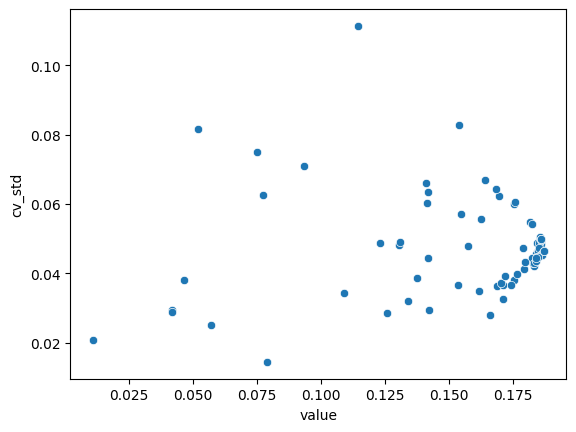

In [44]:
sns.scatterplot(study_df[study_df["value"] != -1], x = "value", y = "cv_std")

In [49]:
study_df["adj_value"] = study_df["value"] - 2 * study_df["cv_std"]
study_df.sort_values("adj_value", ascending=False, ignore_index=True).head(30)

,log2_hidden_layer_0,log2_hidden_layer_1,lr,batch_size,num_epochs,value,cv_std,adj_value
0,6,5,0.000336,360,5,0.165849,0.027990,0.109869
1,6,5,0.000299,360,5,0.170981,0.032682,0.105618
2,5,4,0.000290,360,5,0.174063,0.036701,0.100661
3,5,4,0.000114,360,10,0.183362,0.042009,0.099345
4,5,2,0.000397,360,5,0.175470,0.038064,0.099342
5,6,5,0.000169,120,5,0.171040,0.036663,0.097715
6,6,5,0.000166,720,10,0.183313,0.043062,0.097189
7,5,4,0.000254,360,5,0.176728,0.039800,0.097129
8,6,5,0.000208,360,15,0.179390,0.041284,0.096821
9,6,5,0.000157,720,10,0.183931,0.043669,0.096594


#### Twelth Trial: AE-MLP but MLP step is concat of good features + AE features

In [ ]:
# Custom function for batch iteration
def batch_iterate_with_concat(batch_size, X, Y, X_good, shuffle = True):
    for i in range(0, Y.size, batch_size):
        X_curr = X[i: min(i + batch_size, Y.size), :]
        Y_curr = Y[i: min(i + batch_size, Y.size)]
        X_good_curr = X_good[i: min(i + batch_size, Y.size), :]
        if shuffle:
            inx_lst = mx.random.permutation(batch_size)
            X_curr = X_curr[inx_lst, :]
            Y_curr = Y_curr[inx_lst]
            X_good_curr = X_good_curr[inx_lst, :]
        yield X_curr, Y_curr, X_good_curr

In [ ]:
# Separate function for train & eval step
def train_aemlp_mlx_with_concat(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                                mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                                X_train, Y_train, X_train_good, batch_size):
    # Train ae first
    ae_model.train()
    for _ in tqdm(range(ae_num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            # get gradients for ae, output is the inputs itself
            _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

            # Update the optimizer state and model parameters in a single call
            ae_optimizer.update(ae_model, ae_grads)

            # Force a graph evaluation
            mx.eval(ae_model.parameters(), ae_optimizer.state)

    # Train mlp later
    mlp_model.train()
    for _ in tqdm(range(mlp_num_epochs)):
        for (inputs, targets, inputs_good) in batch_iterate_with_concat(batch_size, X_train, Y_train, X_train_good):
            # get the latent representation for X_train
            latent_inputs = ae_model.get_latent(inputs)
            used_inputs = mx.concatenate([inputs_good, latent_inputs], axis=1)
            # get gradients for mlp
            _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

            # Update the optimizer state and model parameters in a single call
            mlp_optimizer.update(mlp_model, mlp_grads)

            # Force a graph evaluation
            mx.eval(mlp_model.parameters(), mlp_optimizer.state)

    # # Train ae and mlp together
    # ae_model.train()
    # mlp_model.train()
    # for _ in tqdm(range(ae_num_epochs)):
    #     for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
    #         # get gradients for ae, output is the inputs itself
    #         _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

    #         # Update the optimizer state and model parameters in a single call
    #         ae_optimizer.update(ae_model, ae_grads)

    #         # Force a graph evaluation
    #         mx.eval(ae_model.parameters(), ae_optimizer.state)

    #         # get gradients for mlp
    #         latent_inputs = ae_model.get_latent(inputs)
    #         used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
    #         _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

    #         # Update the optimizer state and model parameters in a single call
    #         mlp_optimizer.update(mlp_model, mlp_grads)

    #         # Force a graph evaluation
    #         mx.eval(mlp_model.parameters(), mlp_optimizer.state)

def eval_aemlp_mlx_with_concat(ae_model, mlp_model, X_test, Y_test, X_test_good, batch_size):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    ae_model.eval()
    mlp_model.eval()
    for (inputs, targets, inputs_good) in batch_iterate_with_concat(batch_size, X_test, Y_test, X_test_good, shuffle=False):
        latent_inputs = ae_model.get_latent(inputs)
        used_inputs = mx.concatenate([inputs_good, latent_inputs], axis=1)
        outputs = mlp_model(used_inputs).reshape(-1)
        # convert back to numpy
        outputs, targets = np.array(outputs), np.array(targets)
        # Load to overall Y_test, Y_pred to calculate pearson score later
        outputs_all = np.concatenate([outputs_all, outputs])
        targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_mlx_aemlp_with_concat(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                                        mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                                        cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, 
                                        X_train_good_arr, X_test_good_arr, batch_size):
    cv_pearson = 0
    for _, (X_train, X_test, Y_train, Y_test, X_train_good, X_test_good) in enumerate(zip(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, X_train_good_arr, X_test_good_arr)):
        # initialize the model
        mx.random.seed(default_random_state)
        ae_model = AEMLX(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout)

        mx.random.seed(default_random_state)
        mlp_model = MLPMLX(ae_latent_size + X_train_good.shape[1], mlp_hidden_layers_size, mlp_dropout)

        # Initialize the loss function (both use same loss function)
        def loss_fn(model, X, Y):
            Y_pred = model(X).reshape(-1)
            Y = Y.reshape(-1)
            return mx.mean(nnmx.losses.mse_loss(Y_pred, Y))
        ae_loss_and_grad_fn = nnmx.value_and_grad(ae_model, loss_fn)
        mlp_loss_and_grad_fn = nnmx.value_and_grad(mlp_model, loss_fn)

        # Reinitialize the optimizer
        ae_optimizer = optimmx.Adam(learning_rate = ae_lr)
        mlp_optimizer = optimmx.Adam(learning_rate = mlp_lr)

        # Train the model
        train_aemlp_mlx_with_concat(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                                    mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                                    X_train, Y_train, X_train_good, batch_size)

        # Test the model
        pearson = eval_aemlp_mlx_with_concat(ae_model, mlp_model, X_test, Y_test, X_test_good, batch_size)
        print(pearson)
        if pearson == -1:
            return pearson
        cv_pearson += pearson
    return cv_pearson / cv

In [ ]:
def objective_aemlp_mlx_with_concat(trial):
    # First initialize the parameters
    num_features = len(best_features)

    # initialize ae layers
    ae_num_layers = ae_default_num_layers
    ae_log_2_hidden_layers_size = []
    for i in range(ae_num_layers):
        if len(ae_log_2_hidden_layers_size) == 0:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, int(math.ceil(math.log2(num_features)))))
        else:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, ae_log_2_hidden_layers_size[-1]))
    ae_hidden_layers_size = [2**i for i in ae_log_2_hidden_layers_size]
    ae_latent_size = 2**trial.suggest_int("ae_log2_latent_size", 3, ae_log_2_hidden_layers_size[-1])
    ae_dropout = trial.suggest_categorical("ae_dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    ae_lr = trial.suggest_float("ae_lr", 0.0001, 0.01, log=True)
    ae_num_epochs = trial.suggest_categorical("num_epochs", [10, 20, 30, 40, 50])

    # initialize mlp layers
    mlp_num_layers = mlp_default_num_layers
    mlp_log_2_hidden_layers_size = []
    for i in range(mlp_num_layers):
        if len(mlp_log_2_hidden_layers_size) == 0:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, int(math.ceil(math.log2(ae_latent_size + num_features)))))
        else:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, mlp_log_2_hidden_layers_size[-1]))
    mlp_hidden_layers_size = [2**i for i in mlp_log_2_hidden_layers_size]
    mlp_dropout = trial.suggest_categorical("mlp_dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    mlp_lr = trial.suggest_float("mlp_lr", 0.0001, 0.01, log=True)
    # mlp_num_epochs = trial.suggest_categorical("mlp_num_epochs", [10, 20, 30, 40, 50])
    mlp_num_epochs = ae_num_epochs

    # batch size
    batch_size = trial.suggest_categorical("batch_size", [30, 60, 120, 180, 360, 720, 1440])
    
    # Conduct training based on those parameters
    cv_pearson = train_eval_cv_mlx_aemlp_with_concat(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                                                     mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                                                     default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr,
                                                     X_train_good_arr, X_test_good_arr, batch_size)
    
    return cv_pearson

In [ ]:
best_features = [col for col in train_df.columns if "X" in col and "interaction" not in col]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
best_features_good = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                      'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                      'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
X_train_good_arr, X_test_good_arr, _, _ = create_cv(train_df, best_features_good)
for i in range(default_cv):
    X_train_good_arr[i] = float64_to_float32(X_train_good_arr[i])
    X_test_good_arr[i] = float64_to_float32(X_test_good_arr[i])
X_train_good_arr, X_test_good_arr, _, _ = normal_cv_to_mlx_cv(X_train_good_arr, X_test_good_arr)

In [ ]:
ae_default_num_layers = 2
mlp_default_num_layers = 1

In [ ]:
optimize_aemlp_mlx(
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_with_good_concat_study",
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_with_good_concat_study",
    objective_function = objective_aemlp_mlx_with_concat
)